<a href="https://colab.research.google.com/github/vincent4u/Assignment-Code/blob/master/Biomass_Gasification_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project explores the use of biomass combustion for energy generation, emphasizing fluidized bed gasification to enhance efficiency and reduce carbon emissions. It investigates the interactions between feedstock compositions, gasification parameters, and catalyst activity using tree ensemble models, including XGBoost, LightGBM, and RandomForestRegressor, with a focus on model interpretability and precision.

In addition to the primary analysis, I have conducted hyperparameter tuning, SHAP analysis, and partial dependence analysis to further understand model performance and feature impacts.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataBiomass_CE880_1.csv to dataBiomass_CE880_1.csv


**Step 1: Installing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
np.random.seed(42)
from scipy.stats import pearsonr
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**Step 2.:loading the datafile**

In [ ]:
dts=pd.read_csv("/content/dataBiomass_CE880_1.csv")
df=dts.iloc[0:336,1:16]


# **Step 3: Exploratory Data Analysis (EDA)**

In [ ]:
df.head()


Cellulose  Hemicellulose  Lignin   Temp  Pressure  Equivalance mass ratio  \
0       0.46           0.29    0.25  665.0       1.0                    0.25   
1       0.46           0.29    0.25  744.0       1.0                    0.30   
2       0.46           0.29    0.25  811.0       1.0                    0.35   
3       0.46           0.29    0.25  670.0       1.0                    0.25   
4       0.46           0.29    0.25  750.0       1.0                    0.30   

   Steam to biomass mass ratio  Superficial gas velocity     H2     CO    CO2  \
0                          0.0                      0.22   9.70  48.24  35.03   
1                          0.0                      0.22  10.13  40.05  43.48   
2                          0.0                      0.22   9.61  36.16  48.61   
3                          0.0                      0.28   9.69  46.99  37.26   
4                          0.0                      0.28   9.37  39.76  45.36   

    CH4  Lower heating value  Char yield  tar yield  
0  7.03                 9.65        24.0        0.0  
1  6.35                 8.42        21.7        0.0  
2  5.62                 7.61        19.0        0.0  
3  6.06                 9.14        29.6        0.0  
4  5.51                 8.00        27.4        0.0

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cellulose                    336 non-null    float64
 1   Hemicellulose                336 non-null    float64
 2   Lignin                       336 non-null    float64
 3   Temp                         336 non-null    float64
 4   Pressure                     336 non-null    float64
 5   Equivalance mass ratio       336 non-null    float64
 6   Steam to biomass mass ratio  336 non-null    float64
 7   Superficial gas velocity     336 non-null    float64
 8   H2                           336 non-null    float64
 9   CO                           336 non-null    float64
 10  CO2                          336 non-null    float64
 11  CH4                          336 non-null    float64
 12  Lower heating value          336 non-null    float64
 13  Char yield          

In [ ]:
df.describe().T

count        mean        std     min       25%  \
Cellulose                    336.0    0.452768   0.080908    0.20    0.4400   
Hemicellulose                336.0    0.281012   0.088878    0.08    0.2500   
Lignin                       336.0    0.266637   0.087562    0.10    0.2000   
Temp                         336.0  752.547530  85.306424  600.00  657.5000   
Pressure                     336.0    1.246518   0.949579    1.00    1.0000   
Equivalance mass ratio       336.0    0.181250   0.166888    0.00    0.0000   
Steam to biomass mass ratio  336.0    0.578036   1.134756    0.00    0.0000   
Superficial gas velocity     336.0    0.747321   1.221580    0.02    0.1900   
H2                           336.0   25.997113  10.132765    5.39   20.6425   
CO                           336.0   31.618393   6.825788    5.01   27.6225   
CO2                          336.0   31.782500   8.802649    6.78   25.1325   
CH4                          336.0   10.581607   3.978859    1.31    7.7975   
Lower heating value          336.0    6.813780   2.820859    1.74    4.8675   
Char yield                   336.0   11.288274  10.626659    0.00    3.2000   
tar yield                    336.0   16.546964  22.510650    0.00    0.0100   

                                 50%       75%     max  
Cellulose                      0.450    0.5000    0.58  
Hemicellulose                  0.290    0.3300    0.63  
Lignin                         0.250    0.3000    0.49  
Temp                         780.000  815.0000  900.00  
Pressure                       1.000    1.0000   10.00  
Equivalance mass ratio         0.230    0.3000    0.86  
Steam to biomass mass ratio    0.330    0.7000    8.03  
Superficial gas velocity       0.555    0.7100    9.59  
H2                            26.405   31.0650   66.03  
CO                            32.575   35.9275   55.44  
CO2                           30.475   36.8400   62.56  
CH4                            9.535   13.7025   20.12  
Lower heating value            6.560    8.3225   14.96  
Char yield                     6.880   17.9000   45.00  
tar yield                      6.640   25.1000  134.10

**Observing the distribution curve of the Target variable**

<Figure size 1170x827 with 0 Axes>

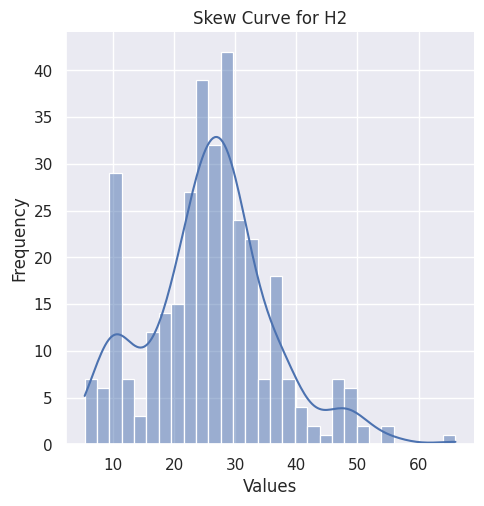

<Figure size 1170x827 with 0 Axes>

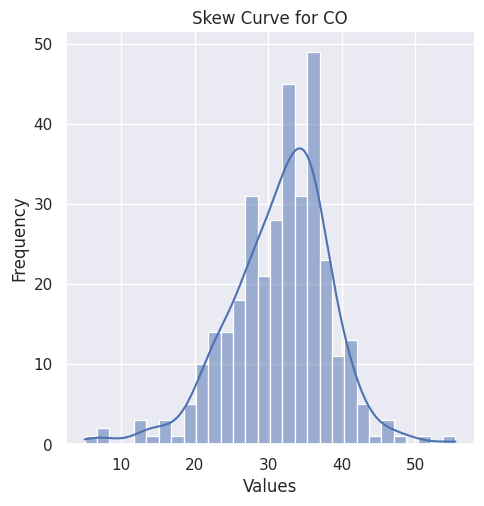

<Figure size 1170x827 with 0 Axes>

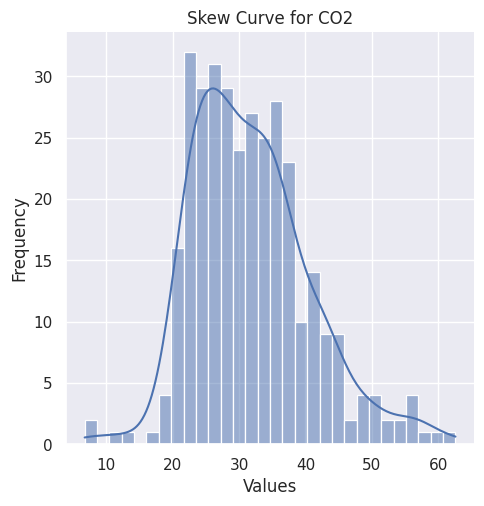

<Figure size 1170x827 with 0 Axes>

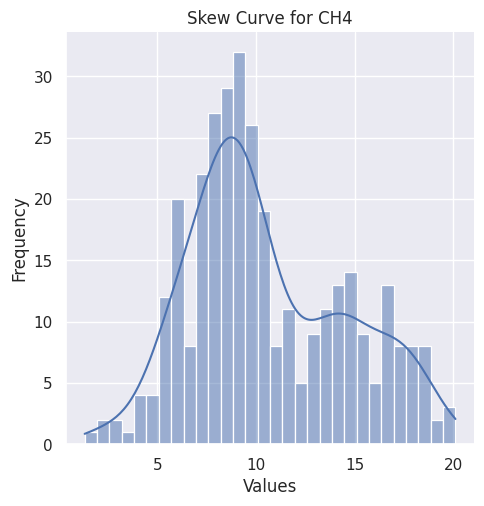

<Figure size 1170x827 with 0 Axes>

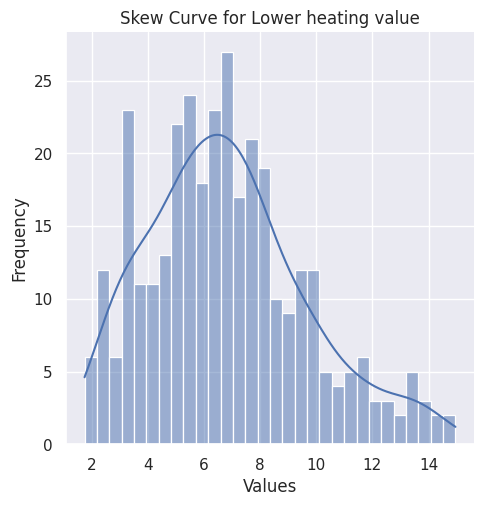

<Figure size 1170x827 with 0 Axes>

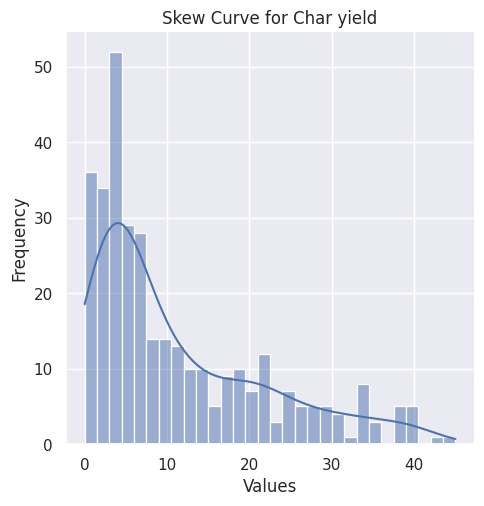

<Figure size 1170x827 with 0 Axes>

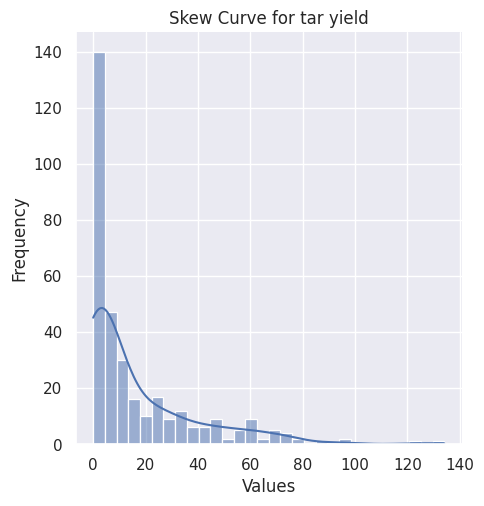

In [ ]:
targets = ['H2', 'CO', 'CO2', 'CH4', 'Lower heating value', 'Char yield', 'tar yield']
# Setting the figure size
sns.set(rc={'figure.figsize': (11.7, 8.27)})

# Ploting the density curve and histogram-like plot for each column in columns_of_interest
for column in targets:
    plt.figure()  # Create a new figure for each column
    sns.displot(df[column], bins=30, kde=True)
    plt.title('Skew Curve for ' + column)
    plt.xlabel('Values')
    plt.ylabel('Frequency')

plt.show()

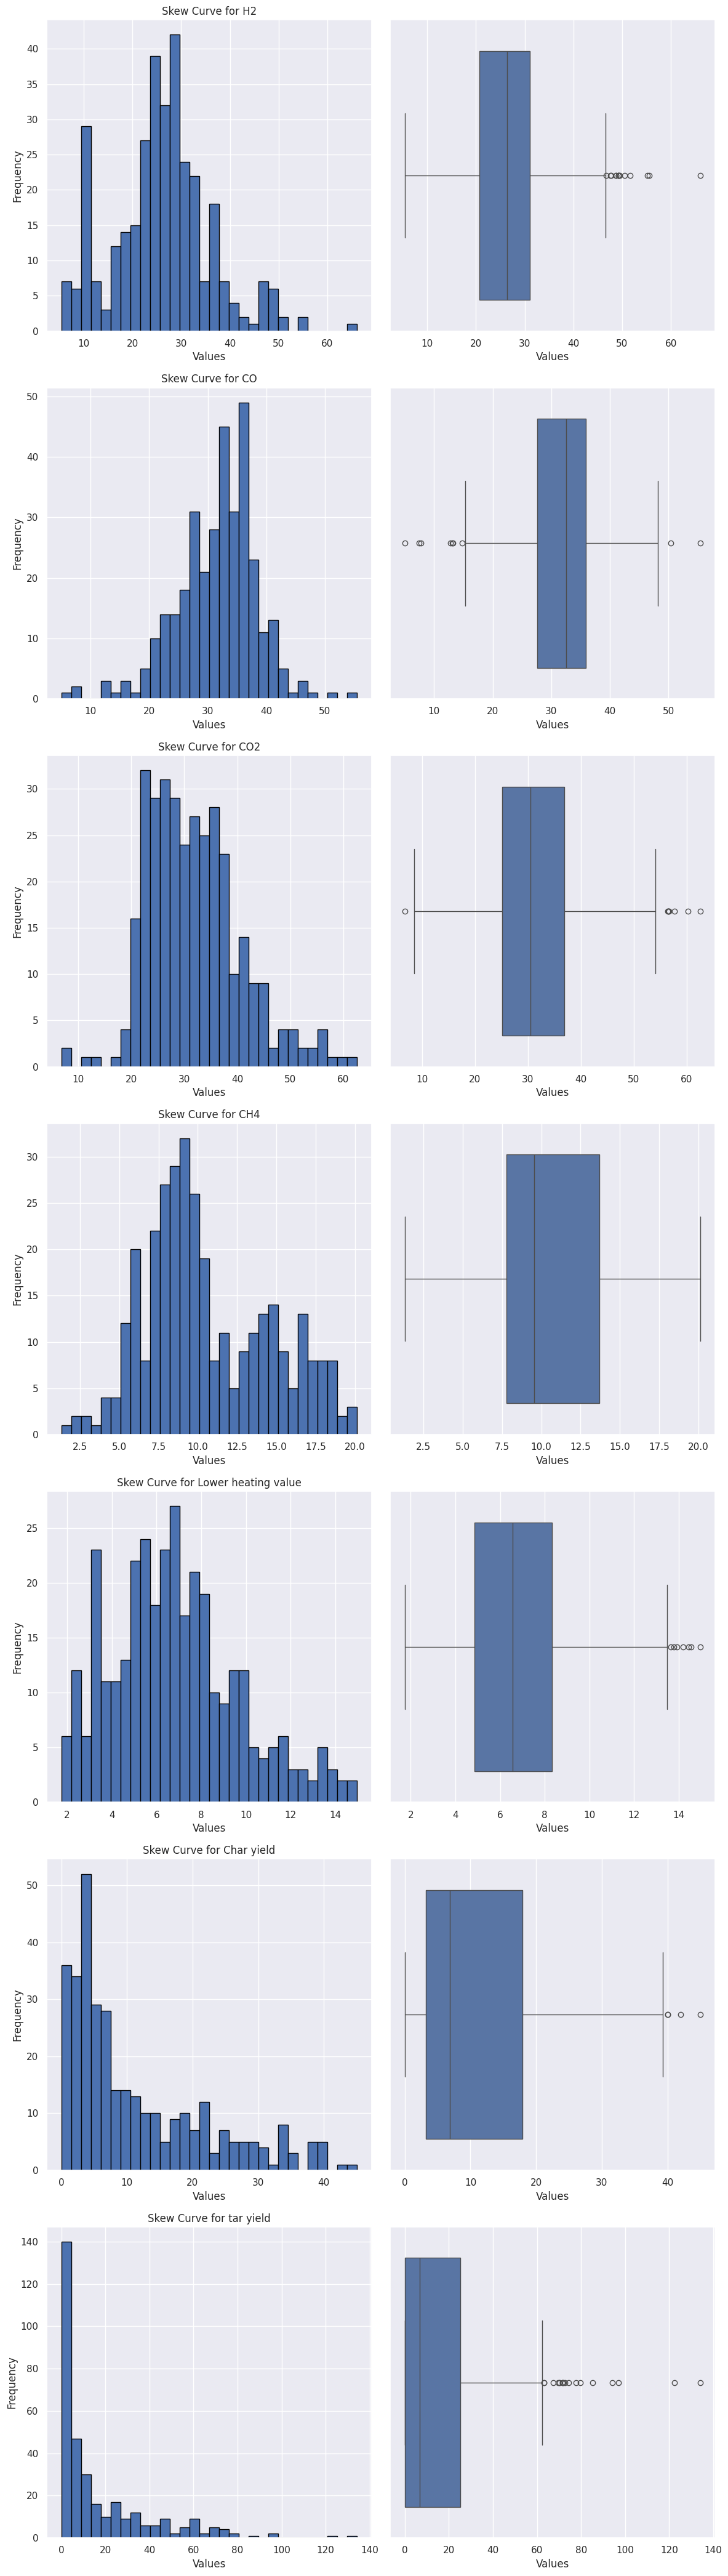

In [ ]:
## visualizing outliers: for better decision making
# The columns of interest
targets = ['H2', 'CO', 'CO2', 'CH4', 'Lower heating value', 'Char yield', 'tar yield']

# Creating subplots for each column in the columns_of_interest
fig, axes = plt.subplots(nrows=len(targets), ncols=2, figsize=(12, 6 * len(targets)))

if len(targets) == 1:
    column = targets[0]
    axes[0][0].hist(df[column], bins=30, edgecolor='black')
    axes[0][0].set_xlabel('Values')
    axes[0][0].set_ylabel('Frequency')
    axes[0][0].set_title('Skew Curve for ' + column)
    sns.boxplot(x=df[column], ax=axes[0][1])
    axes[0][1].set_xlabel('Values')
    axes[0][1].set_ylabel('')

else:
    for i, column in enumerate(targets):
        ax_hist = axes[i][0]
        ax_box = axes[i][1]
        ax_hist.hist(df[column], bins=30, edgecolor='black')
        ax_hist.set_xlabel('Values')
        ax_hist.set_ylabel('Frequency')
        ax_hist.set_title('Skew Curve for ' + column)
        sns.boxplot(x=df[column], ax=ax_box)
        ax_box.set_xlabel('Values')
        ax_box.set_ylabel('')
        ax_box.get_yaxis().set_visible(False)  # Hide y-axis labels for boxplot

plt.tight_layout()
plt.show()

**calculating Pearson correlations between each feature and each target variable**

In [ ]:
from scipy.stats import pearsonr

features = df[['Cellulose', 'Hemicellulose', 'Lignin', 'Temp', 'Pressure', 'Equivalance mass ratio', 'Steam to biomass mass ratio', 'Superficial gas velocity']]
targets = df[['H2', 'CO', 'CO2', 'CH4', 'Lower heating value', 'Char yield', 'tar yield']]
# Assuming features and targets are your DataFrames
for feature_column in features.columns:
    for target_column in targets.columns:
        correlation, _ = pearsonr(features[feature_column], targets[target_column])
        print(f'Pearson correlation between {feature_column} and {target_column}: {correlation:.2f}')

Pearson correlation between Cellulose and H2: 0.03
Pearson correlation between Cellulose and CO: 0.02
Pearson correlation between Cellulose and CO2: -0.10
Pearson correlation between Cellulose and CH4: 0.11
Pearson correlation between Cellulose and Lower heating value: -0.14
Pearson correlation between Cellulose and Char yield: -0.26
Pearson correlation between Cellulose and tar yield: -0.03
Pearson correlation between Hemicellulose and H2: 0.07
Pearson correlation between Hemicellulose and CO: -0.06
Pearson correlation between Hemicellulose and CO2: -0.10
Pearson correlation between Hemicellulose and CH4: 0.17
Pearson correlation between Hemicellulose and Lower heating value: -0.06
Pearson correlation between Hemicellulose and Char yield: -0.20
Pearson correlation between Hemicellulose and tar yield: 0.20
Pearson correlation between Lignin and H2: -0.09
Pearson correlation between Lignin and CO: 0.04
Pearson correlation between Lignin and CO2: 0.19
Pearson correlation between Lignin a

In [ ]:
features = df[['Cellulose', 'Hemicellulose', 'Lignin', 'Temp', 'Pressure', 'Equivalance mass ratio', 'Steam to biomass mass ratio', 'Superficial gas velocity']]
targets = df[['H2', 'CO', 'CO2', 'CH4', 'Lower heating value', 'Char yield', 'tar yield']]


# **Step 4: Normalization**


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

# Set up features (X)
features = df[['Cellulose', 'Hemicellulose', 'Lignin', 'Temp', 'Pressure',
                'Equivalance mass ratio', 'Steam to biomass mass ratio',
                'Superficial gas velocity']]
X = pd.DataFrame(features.values, columns=features.columns)

# Set up targets (y)
targets = df[['H2', 'CO', 'CO2', 'CH4', 'Lower heating value', 'Char yield', 'tar yield']]
y = pd.DataFrame(targets.values, columns=targets.columns)

# Split the dataset into training and testing sets first
features_train, features_test, targets_train, targets_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RobustScaler for features
feature_scaler = RobustScaler()

# Fit and transform the features
X_train = feature_scaler.fit_transform(features_train)
X_test = feature_scaler.transform(features_test)

# Convert the scaled arrays back to DataFrames with original column names
X_train = pd.DataFrame(X_train, columns=features.columns)
X_test = pd.DataFrame(X_test, columns=features.columns)

# Initialize StandardScaler for targets
target_scaler = StandardScaler()

# Fit and transform the targets
y_train = target_scaler.fit_transform(targets_train)
y_test = target_scaler.transform(targets_test)

# Convert the scaled targets back to DataFrames with original column names
y_train = pd.DataFrame(y_train, columns=targets.columns)
y_test = pd.DataFrame(y_test, columns=targets.columns)


**Step 5: implementing the Models**

# **model = XGBRegressor(tree_method='hist')**

RMSE Scores: [0.43118384 0.6265512  0.42430107 0.33852984 0.35788265 0.5922624
 0.39914128]
R^2 Scores: [0.8474218 0.6899885 0.8369707 0.8927778 0.8560309 0.6543003 0.7931613]
R^2 Scores: 0.7958073616027832


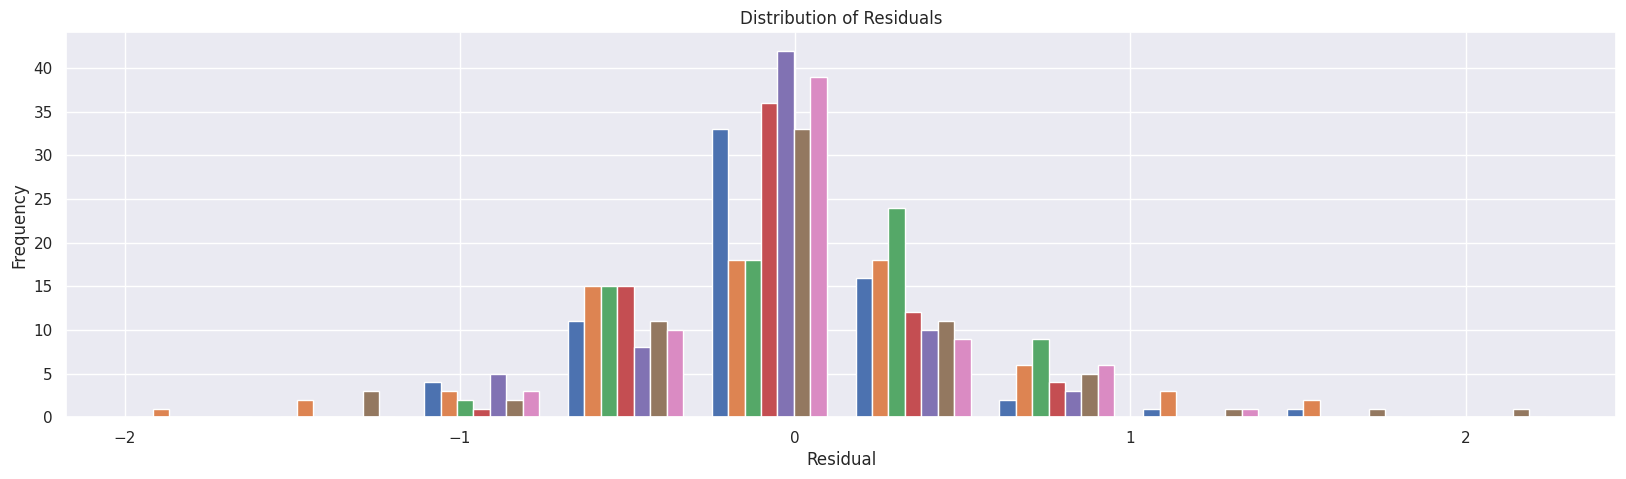

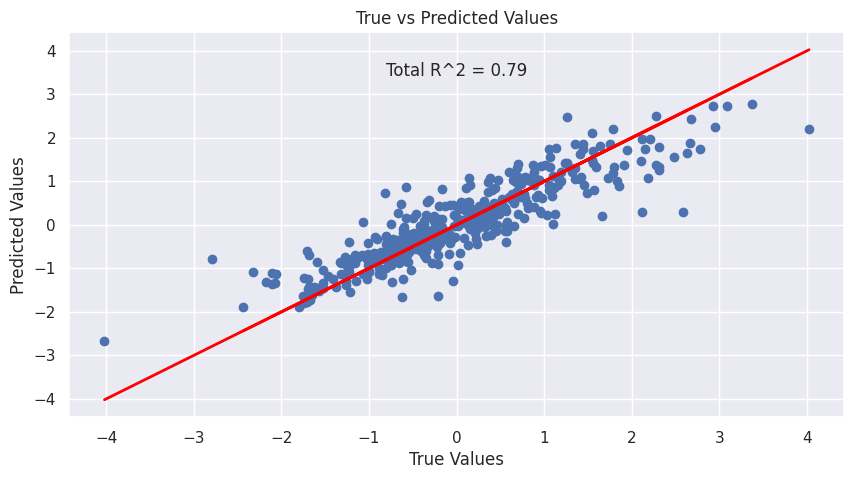

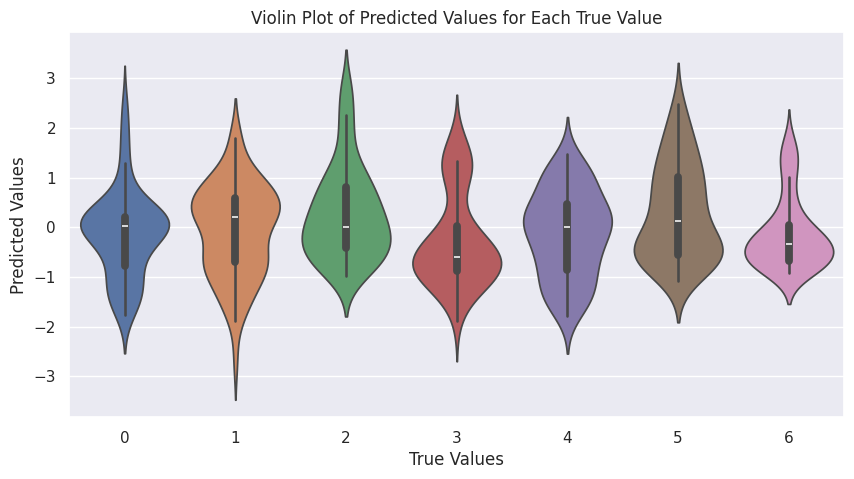

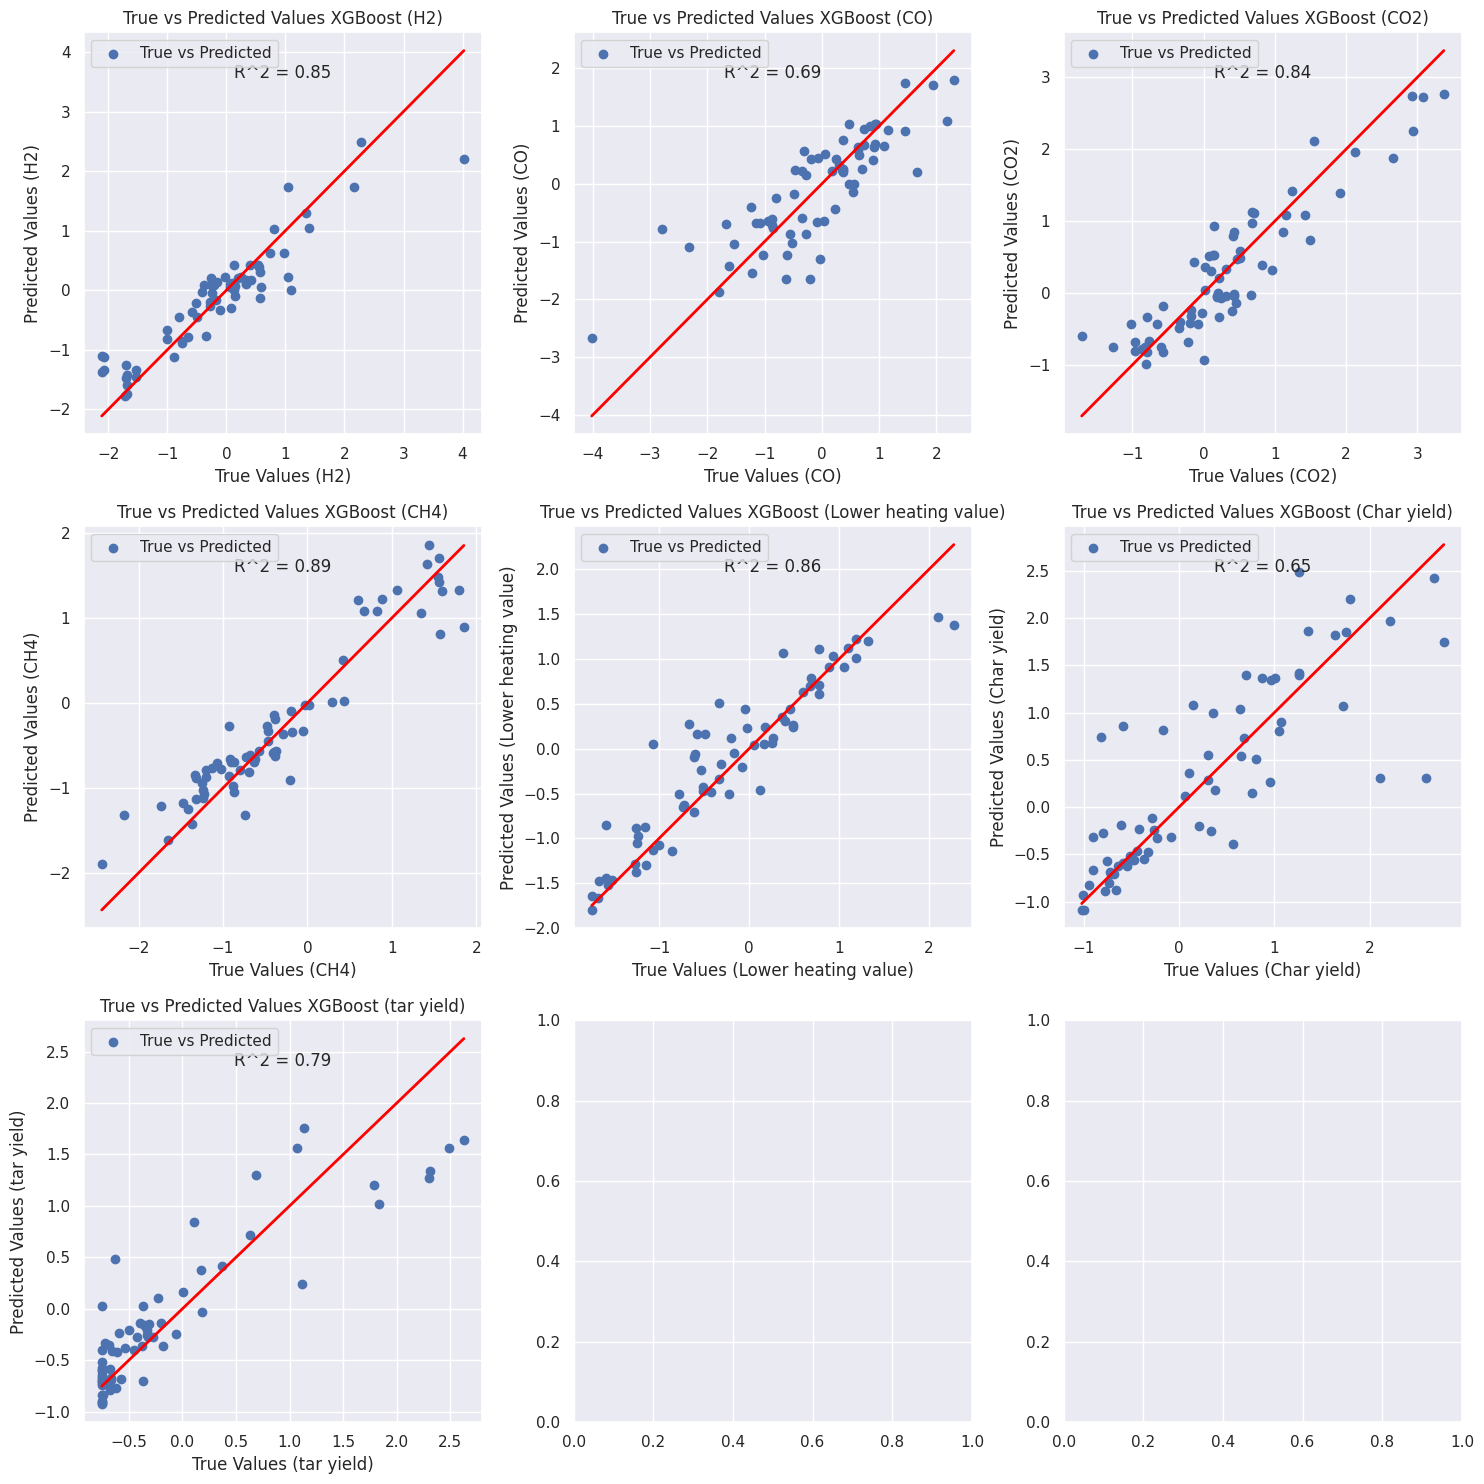

<Figure size 1170x827 with 0 Axes>

In [ ]:
# Define and train the model
best_params = {
    "objective": "reg:squarederror",
    "n_estimators": 500,
    "verbosity": 0,
    "learning_rate": 0.0255709534112944,
    "max_depth": 6,
    "subsample":  0.8750699631919016,
    "colsample_bytree": 0.41208987840060635,
    "min_child_weight": 10
}

# Create an XGBRegressor model with the best hyperparameters

model = XGBRegressor(**best_params,tree_method='hist')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate RMSE for each target column in y_pred
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE Scores:", rmse_scores)

r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
print("R^2 Scores:", r2_scores)

r2_scores = r2_score(y_test, y_pred)
print("R^2 Scores:", r2_scores)

residuals = y_test - y_pred
plt.figure(figsize=(20, 5))
plt.hist(residuals, bins=10)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

# Calculate and print R^2 value
r2_total = r2_score(y_test, y_pred, multioutput='variance_weighted')
plt.text(0.5, 0.9, f'Total R^2 = {r2_total:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()
plt.figure(figsize=(10, 5))
sns.violinplot(y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Violin Plot of Predicted Values for Each True Value')
plt.show()

# Subplots for each target variable
num_columns = 3
num_rows = (len(targets.columns) + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Loop through each target variable
for i, target_column in enumerate(targets.columns):
    axes[i].scatter(y_test.iloc[:, i], y_pred[:, i], label='True vs Predicted')
    axes[i].plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
                  [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], color='red', linewidth=2)
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    axes[i].text(0.5, 0.9, f'R^2 = {r2:.2f}', ha='center', va='center', transform=axes[i].transAxes)
    axes[i].set_xlabel(f'True Values ({target_column})')
    axes[i].set_ylabel(f'Predicted Values ({target_column})')
    axes[i].set_title(f'True vs Predicted Values XGBoost ({target_column})')
    axes[i].legend()

plt.tight_layout()
fig.savefig('XGBoost_figure.png')
plt.show()


plt.tight_layout()

# Save the figure
fig.savefig('XGBoost_figure.png')

# Show the figure
plt.show()

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.4 MB/s eta 0:00:00


**Hyperparameter tuning for XGBRegressor**

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    # Split your data into training and validation sets
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=10),  # Adjust the range as needed
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

***Implementing Best_param for XGBoostRegressor***

# ***Refined X-gboost***

RMSE Scores: [0.38022842 0.57828503 0.39092927 0.3287123  0.32580858 0.59879766
 0.38330055]
R^2 Scores: [0.8813531  0.7359121  0.8616071  0.8989066  0.88068    0.646629
 0.80925316]
Overall R^2 Score: 0.8163344264030457


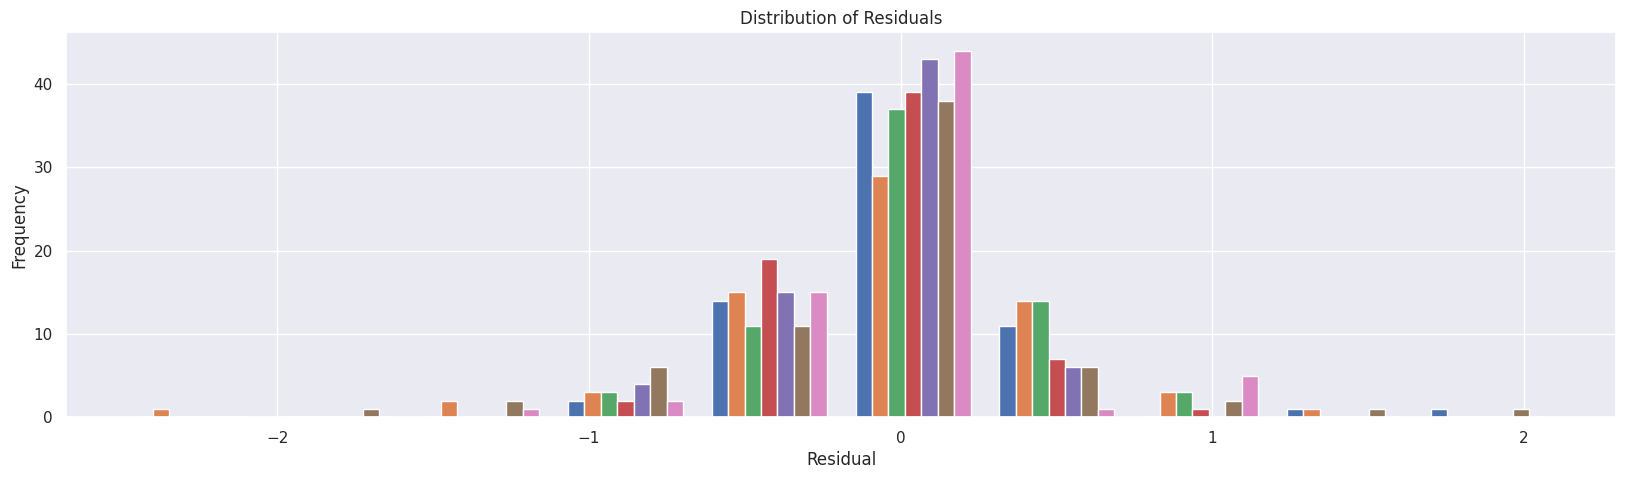

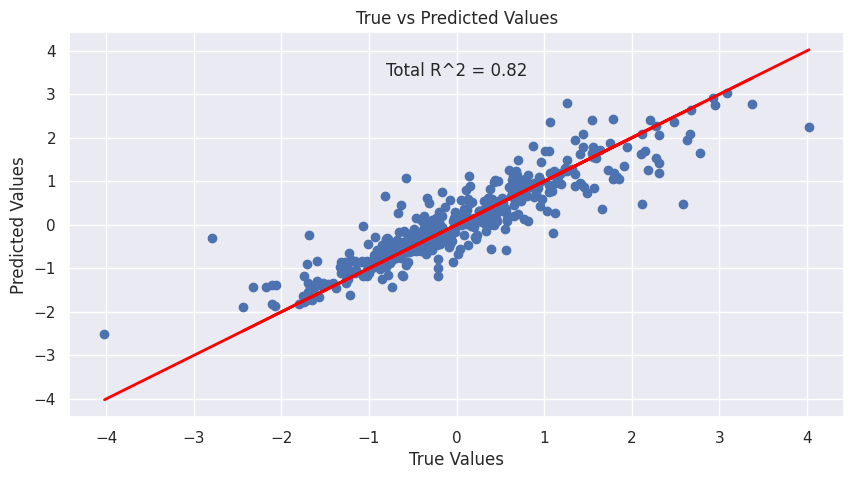

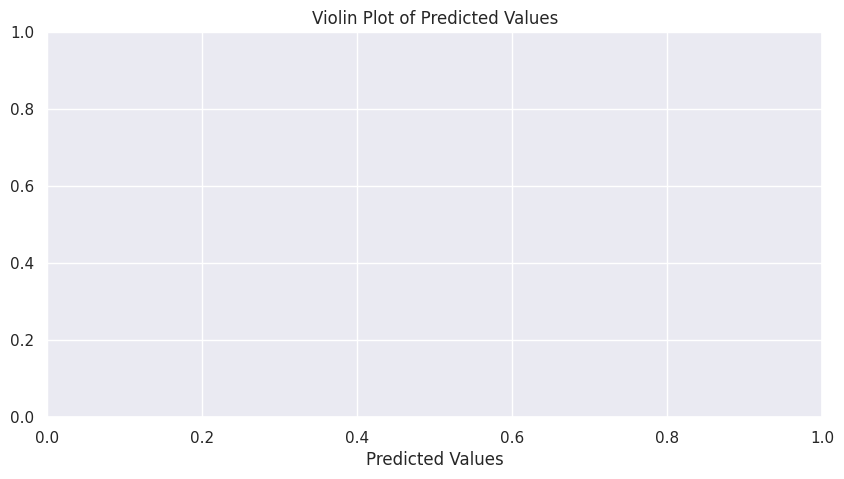

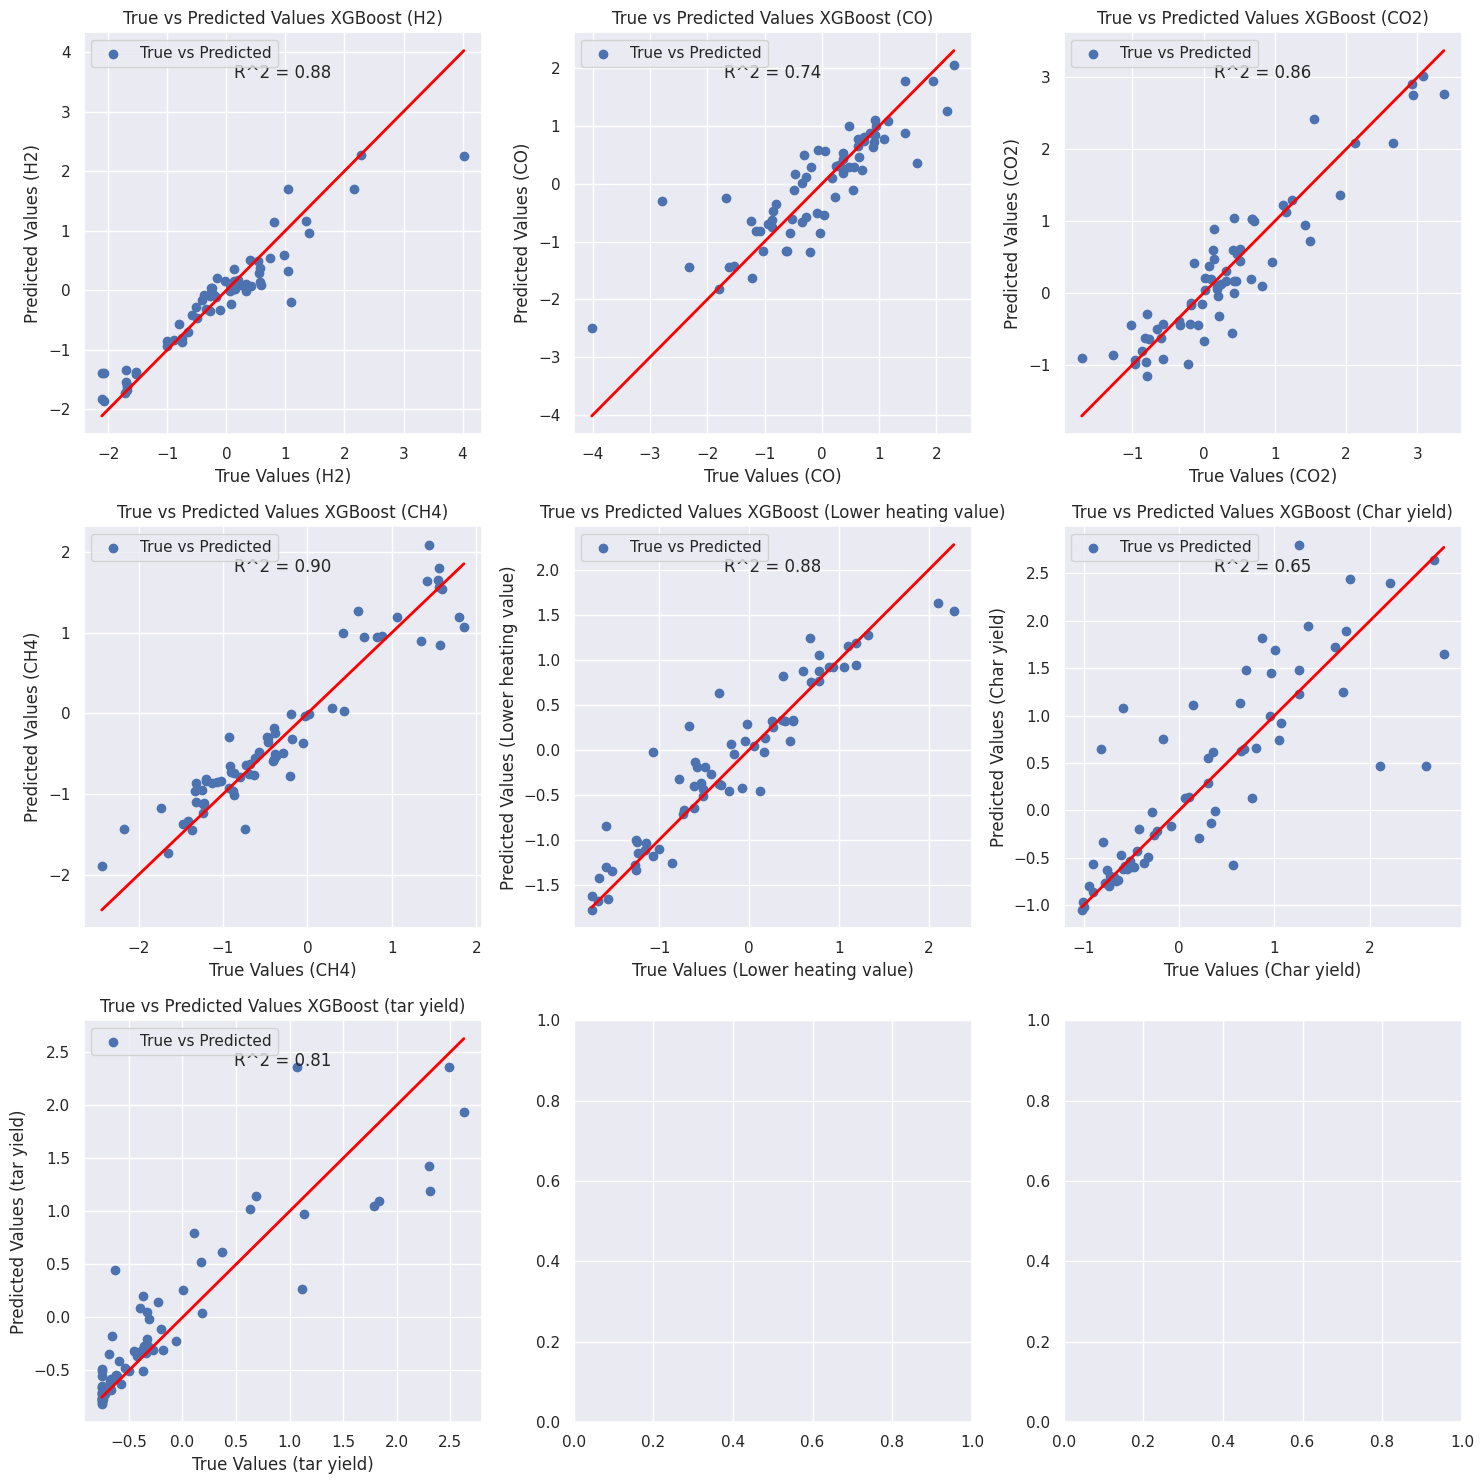

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set up features (X)
features = df[['Cellulose', 'Hemicellulose', 'Lignin', 'Temp', 'Pressure',
                'Equivalance mass ratio', 'Steam to biomass mass ratio',
                'Superficial gas velocity']]
X = pd.DataFrame(features.values, columns=features.columns)

# Set up targets (y)
targets = df[['H2', 'CO', 'CO2', 'CH4', 'Lower heating value', 'Char yield', 'tar yield']]
y = pd.DataFrame(targets.values, columns=targets.columns)

# Split the dataset into training and testing sets first
features_train, features_test, targets_train, targets_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RobustScaler for features
feature_scaler = RobustScaler()

# Fit and transform the features
X_train = feature_scaler.fit_transform(features_train)
X_test = feature_scaler.transform(features_test)

# Convert the scaled arrays back to DataFrames with original column names
X_train = pd.DataFrame(X_train, columns=features.columns)
X_test = pd.DataFrame(X_test, columns=features.columns)

# Initialize StandardScaler for targets
target_scaler = StandardScaler()

# Fit and transform the targets
y_train = target_scaler.fit_transform(targets_train)
y_test = target_scaler.transform(targets_test)

# Convert the scaled targets back to DataFrames with original column names
y_train = pd.DataFrame(y_train, columns=targets.columns)
y_test = pd.DataFrame(y_test, columns=targets.columns)

# Set the best hyperparameters found by Optuna
best_params = {
    "objective": "reg:squarederror",
    "n_estimators": 230,
    "verbosity": 0,
    "learning_rate": 0.06974211483527425,
    "max_depth": 5,
    "subsample": 0.6635632489941928,
    "colsample_bytree": 0.5153962652156941,
    "min_child_weight": 2
}

# Create an XGBRegressor model with the best hyperparameters
model = xgb.XGBRegressor(**best_params)

# Train the model on the training data
model.fit(X_train, y_train, verbose=False)

# Make predictions on the validation data
y_pred = model.predict(X_test)

# Calculating RMSE for each target column in y_pred
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE Scores:", rmse_scores)

# Calculating R2 for each target column in y_pred
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
print("R^2 Scores:", r2_scores)

# Calculate and print overall R² score
overall_r2 = r2_score(y_test, y_pred)
print("Overall R^2 Score:", overall_r2)

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(20, 5))
plt.hist(residuals, bins=10)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# True vs Predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

# Display total R^2 value
plt.text(0.5, 0.9, f'Total R^2 = {overall_r2:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

# Violin plot of predicted values (optional)
plt.figure(figsize=(10, 5))
# sns.violinplot(y_pred)
plt.xlabel('Predicted Values')
plt.title('Violin Plot of Predicted Values')
plt.show()

# Subplots for each target variable
num_columns = 3
num_rows = (len(targets.columns) + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Loop through each target variable
for i, target_column in enumerate(targets.columns):
    axes[i].scatter(y_test.iloc[:, i], y_pred[:, i], label='True vs Predicted')
    axes[i].plot([y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
                  [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()], color='red', linewidth=2)
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    axes[i].text(0.5, 0.9, f'R^2 = {r2:.2f}', ha='center', va='center', transform=axes[i].transAxes)
    axes[i].set_xlabel(f'True Values ({target_column})')
    axes[i].set_ylabel(f'Predicted Values ({target_column})')
    axes[i].set_title(f'True vs Predicted Values XGBoost ({target_column})')
    axes[i].legend()

plt.tight_layout()
fig.savefig('XGBoost_figure.png')
plt.show()


***Installing SHAP (SHapley Additive exPlanation)***

In [ ]:
!pip install --upgrade shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.9 MB/s eta 0:00:00


### ***SHAP (SHapley Additive exPlanation) Analysis for X-GBoost ***

SHAP analysis for target variable: H2


 98%|===================| 468/476 [00:38<00:00]       

SHAP analysis for target variable: CO


100%|===================| 475/476 [00:35<00:00]       

SHAP analysis for target variable: CO2


 99%|===================| 470/476 [00:36<00:00]       

SHAP analysis for target variable: CH4


 98%|===================| 467/476 [00:34<00:00]       

SHAP analysis for target variable: Lower heating value


 97%|=================== | 464/476 [00:34<00:00]       

SHAP analysis for target variable: Char yield


 99%|===================| 470/476 [00:36<00:00]       

SHAP analysis for target variable: tar yield


 98%|===================| 465/476 [00:33<00:00]       

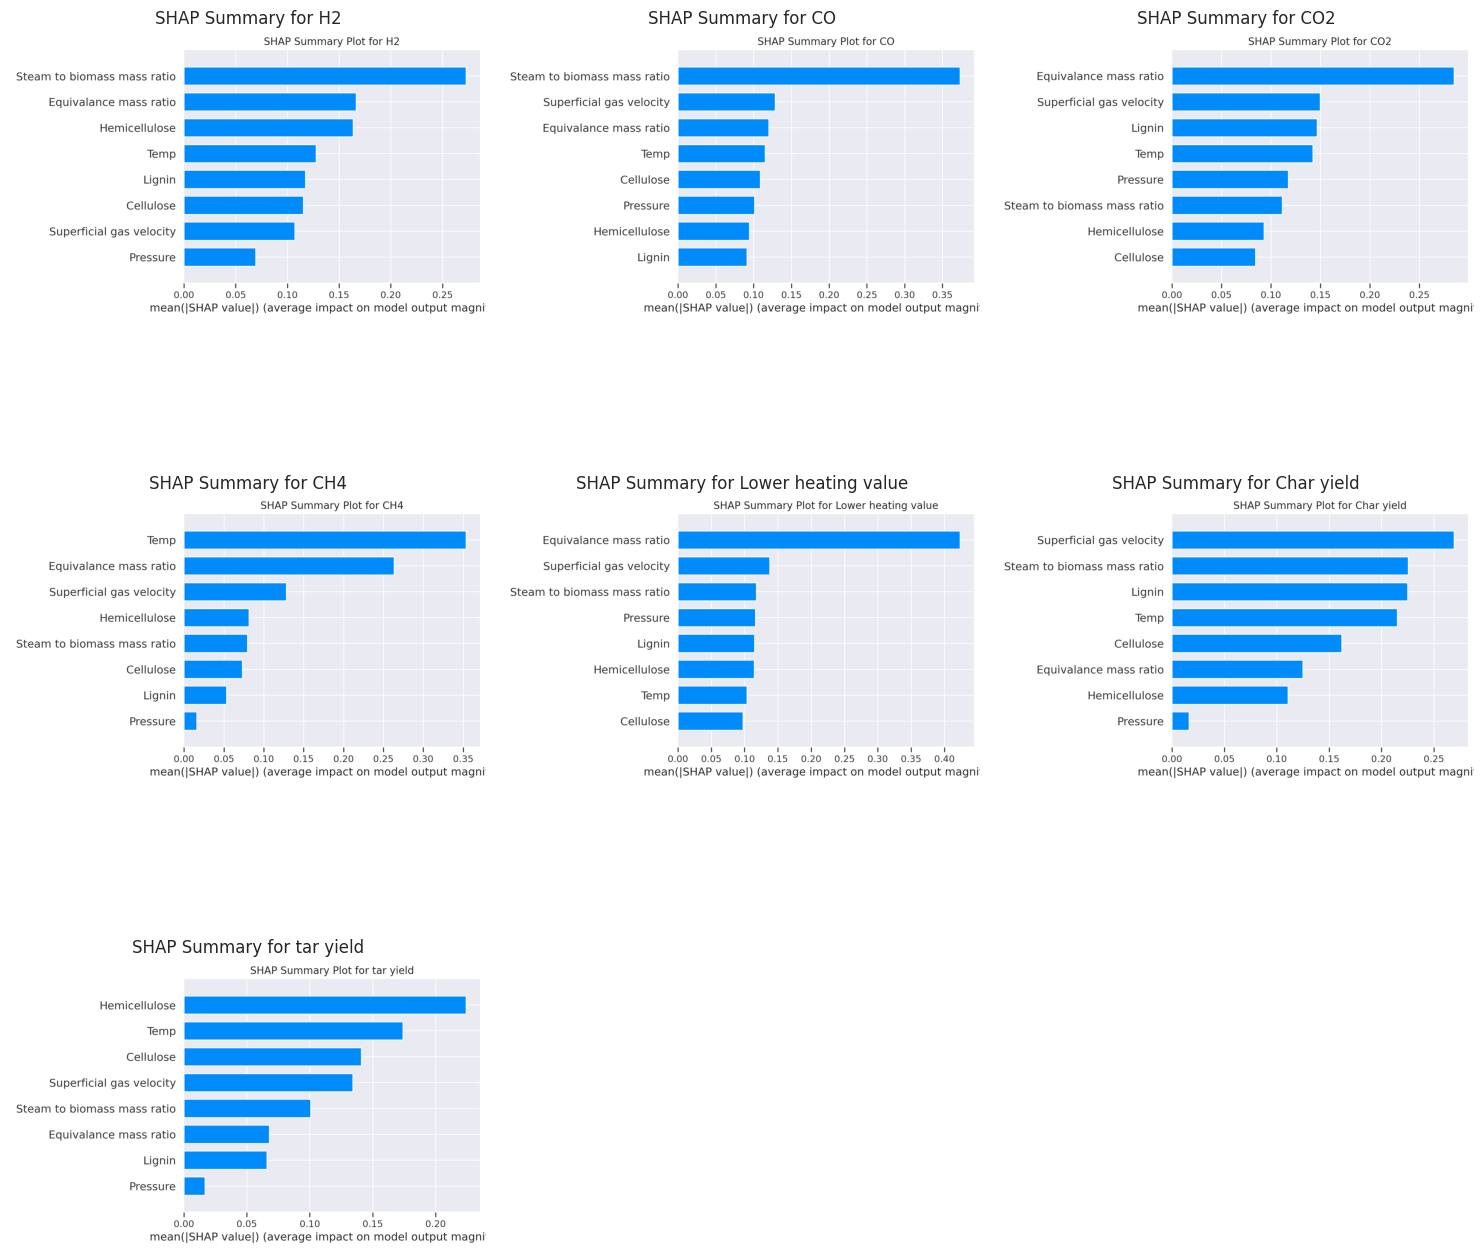

In [ ]:
import matplotlib.pyplot as plt
import shap
import os

# Directory to save individual SHAP plots
if not os.path.exists('shap_plots'):
    os.makedirs('shap_plots')

# Loop over each target variable and generate individual SHAP plots
for i, target_column in enumerate(y.columns):
    print(f"SHAP analysis for target variable: {target_column}")

    # SHAP values for each target separately
    explainer = shap.Explainer(model, X_train)

    # Compute SHAP values (for X_test)
    shap_values = explainer(X_test)

    # Extract the SHAP values for the current target (i-th target)
    shap_values_for_target = shap_values[..., i]

    # SHAP summary plot for the current target
    shap.summary_plot(shap_values_for_target.values, X_test, plot_type="bar", show=False)
    plt.title(f"SHAP Summary Plot for {target_column}")
    plt.savefig(f'shap_plots/shap_summary_{target_column}.png', dpi=200, bbox_inches='tight')
    plt.close()

# Now, combine all the individual SHAP plots into a grid
num_columns = 3
num_rows = (len(y.columns) + num_columns - 1) // num_columns

# Create a figure for combining the plots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Loop through each target variable and add the saved images to the subplots
for i, target_column in enumerate(y.columns):
    img = plt.imread(f'shap_plots/shap_summary_{target_column}.png')
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"SHAP Summary for {target_column}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save the combined figure as a PNG file
plt.subplots_adjust(hspace=0.005)  # Adjust the space between rows
plt.tight_layout()  # Use tight layout after adjusting hspace
plt.savefig('SHAP_analysis_combined.png', dpi=300)
plt.show()


SHAP Dependence plots

In [ ]:
import matplotlib.pyplot as plt
import shap
import os

# Directory to save individual SHAP dependence plots
if not os.path.exists('shap_dependence_plots'):
    os.makedirs('shap_dependence_plots')

# Loop over each target variable and generate SHAP dependence plots for each feature
for i, target_column in enumerate(y.columns):
    print(f"SHAP dependence plots for target variable: {target_column}")

    # SHAP values for each target separately
    explainer = shap.Explainer(model, X_train)

    # Compute SHAP values (for X_test)
    shap_values = explainer(X_test)

    # Extract the SHAP values for the current target (i-th target)
    shap_values_for_target = shap_values[..., i]

    # Generate dependence plots for each feature
    for feature in X_test.columns:
        shap.dependence_plot(feature, shap_values_for_target.values, X_test, show=False)
        plt.title(f"Dependence Plot for {target_column} - {feature}")
        plt.savefig(f'shap_dependence_plots/shap_dependence_{target_column}_{feature}.png', dpi=300, bbox_inches='tight')
        plt.close()

# Now, combine all the individual SHAP dependence plots into a grid for each target variable
num_columns = 3
num_rows = (len(X_test.columns) + num_columns - 1) // num_columns

# Loop through each target variable to add the saved images to the subplots
for i, target_column in enumerate(y.columns):
    print(f"Combining plots for target variable: {target_column}")

    # Create a figure for combining the plots for this target variable
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    # Loop through each feature and add to the grid
    for j, feature in enumerate(X_test.columns):
        img_path = f'shap_dependence_plots/shap_dependence_{target_column}_{feature}.png'

        # Check if the image file exists
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            axes[j].imshow(img)
            axes[j].axis('off')  # Hide axes
            axes[j].set_title(f"{target_column} - {feature}")
        else:
            print(f"Warning: File {img_path} not found.")

    # Hide any unused subplots for this target variable
    for k in range(len(X_test.columns), len(axes)):
        axes[k].set_visible(False)

    # Adjust layout and spacing
    plt.subplots_adjust(hspace=0.005)  # Adjust the space between rows
    plt.tight_layout()  # Use tight layout after adjusting hspace
    plt.savefig(f'SHAP_dependence_combined_{target_column}.png', dpi=300)
    plt.show()

    # Clear the current figure for the next target variable
    plt.clf()

In [ ]:
!pip install --upgrade scikit-learn

# ***SHAP Dependence and Partial Dependence plots***

SHAP dependence plots for target variable: H2


100%|===================| 475/476 [00:50<00:00]       

Generating Partial Dependence Plots for target variable: H2
SHAP dependence plots for target variable: CO


 97%|=================== | 462/476 [00:34<00:01]       

Generating Partial Dependence Plots for target variable: CO
SHAP dependence plots for target variable: CO2


 98%|===================| 468/476 [00:35<00:00]       

Generating Partial Dependence Plots for target variable: CO2
SHAP dependence plots for target variable: CH4


 98%|===================| 467/476 [00:34<00:00]       

Generating Partial Dependence Plots for target variable: CH4
SHAP dependence plots for target variable: Lower heating value


 99%|===================| 470/476 [00:36<00:00]       

Generating Partial Dependence Plots for target variable: Lower heating value
SHAP dependence plots for target variable: Char yield


 98%|===================| 466/476 [00:35<00:00]       

Generating Partial Dependence Plots for target variable: Char yield
SHAP dependence plots for target variable: tar yield


100%|===================| 475/476 [00:37<00:00]       

Generating Partial Dependence Plots for target variable: tar yield
Combining plots for target variable: H2


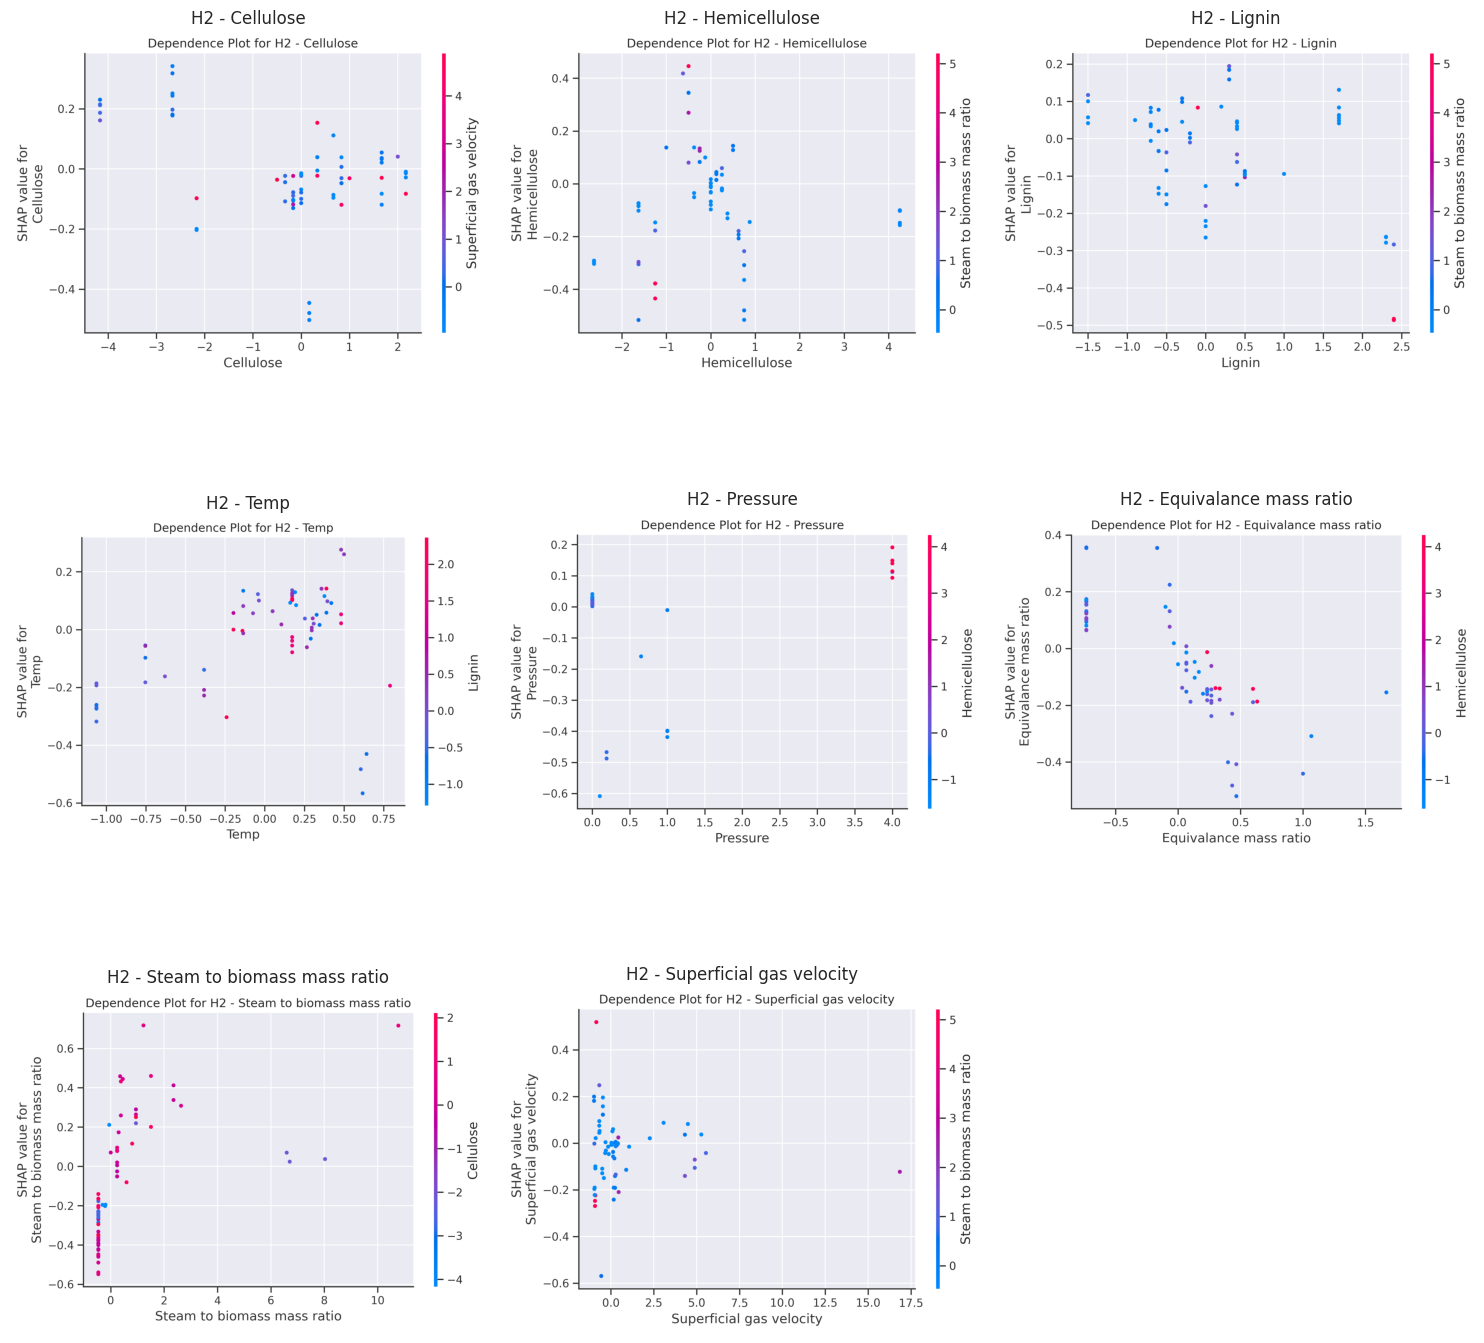

Combining plots for target variable: CO


<Figure size 1170x827 with 0 Axes>

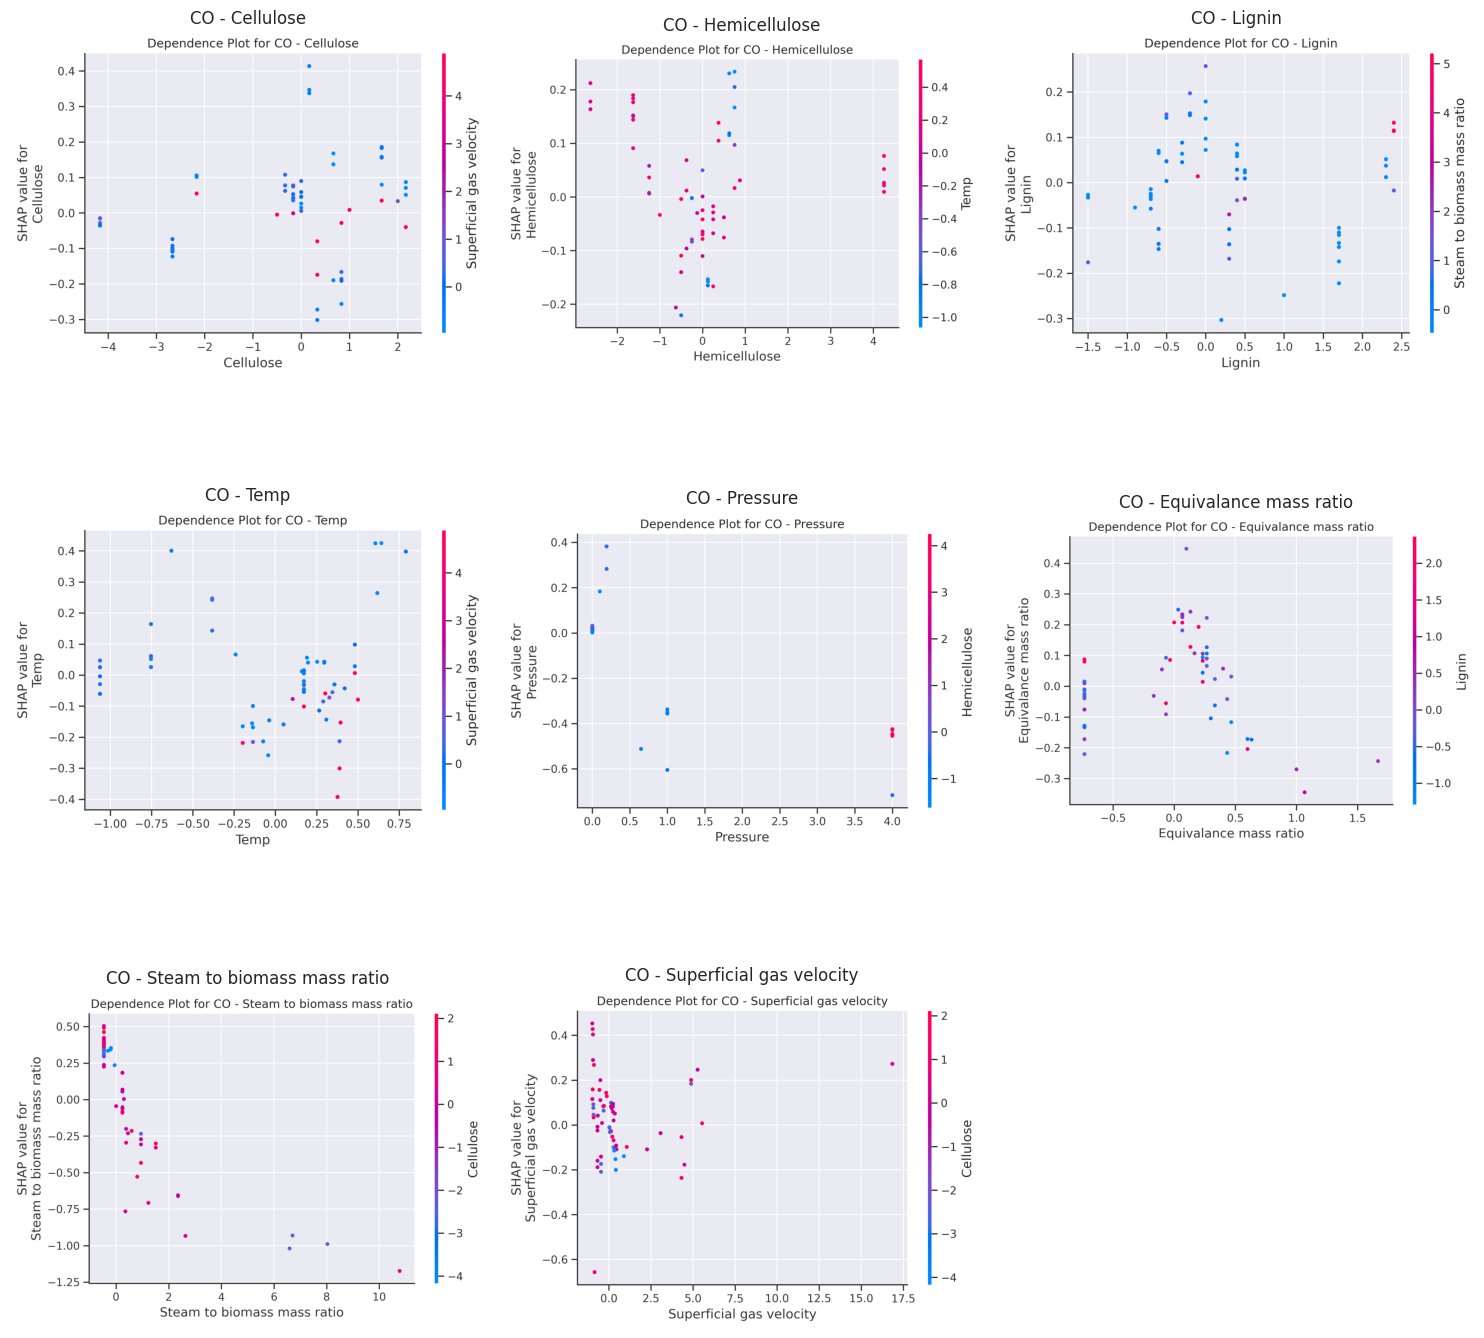

Combining plots for target variable: CO2


<Figure size 1170x827 with 0 Axes>

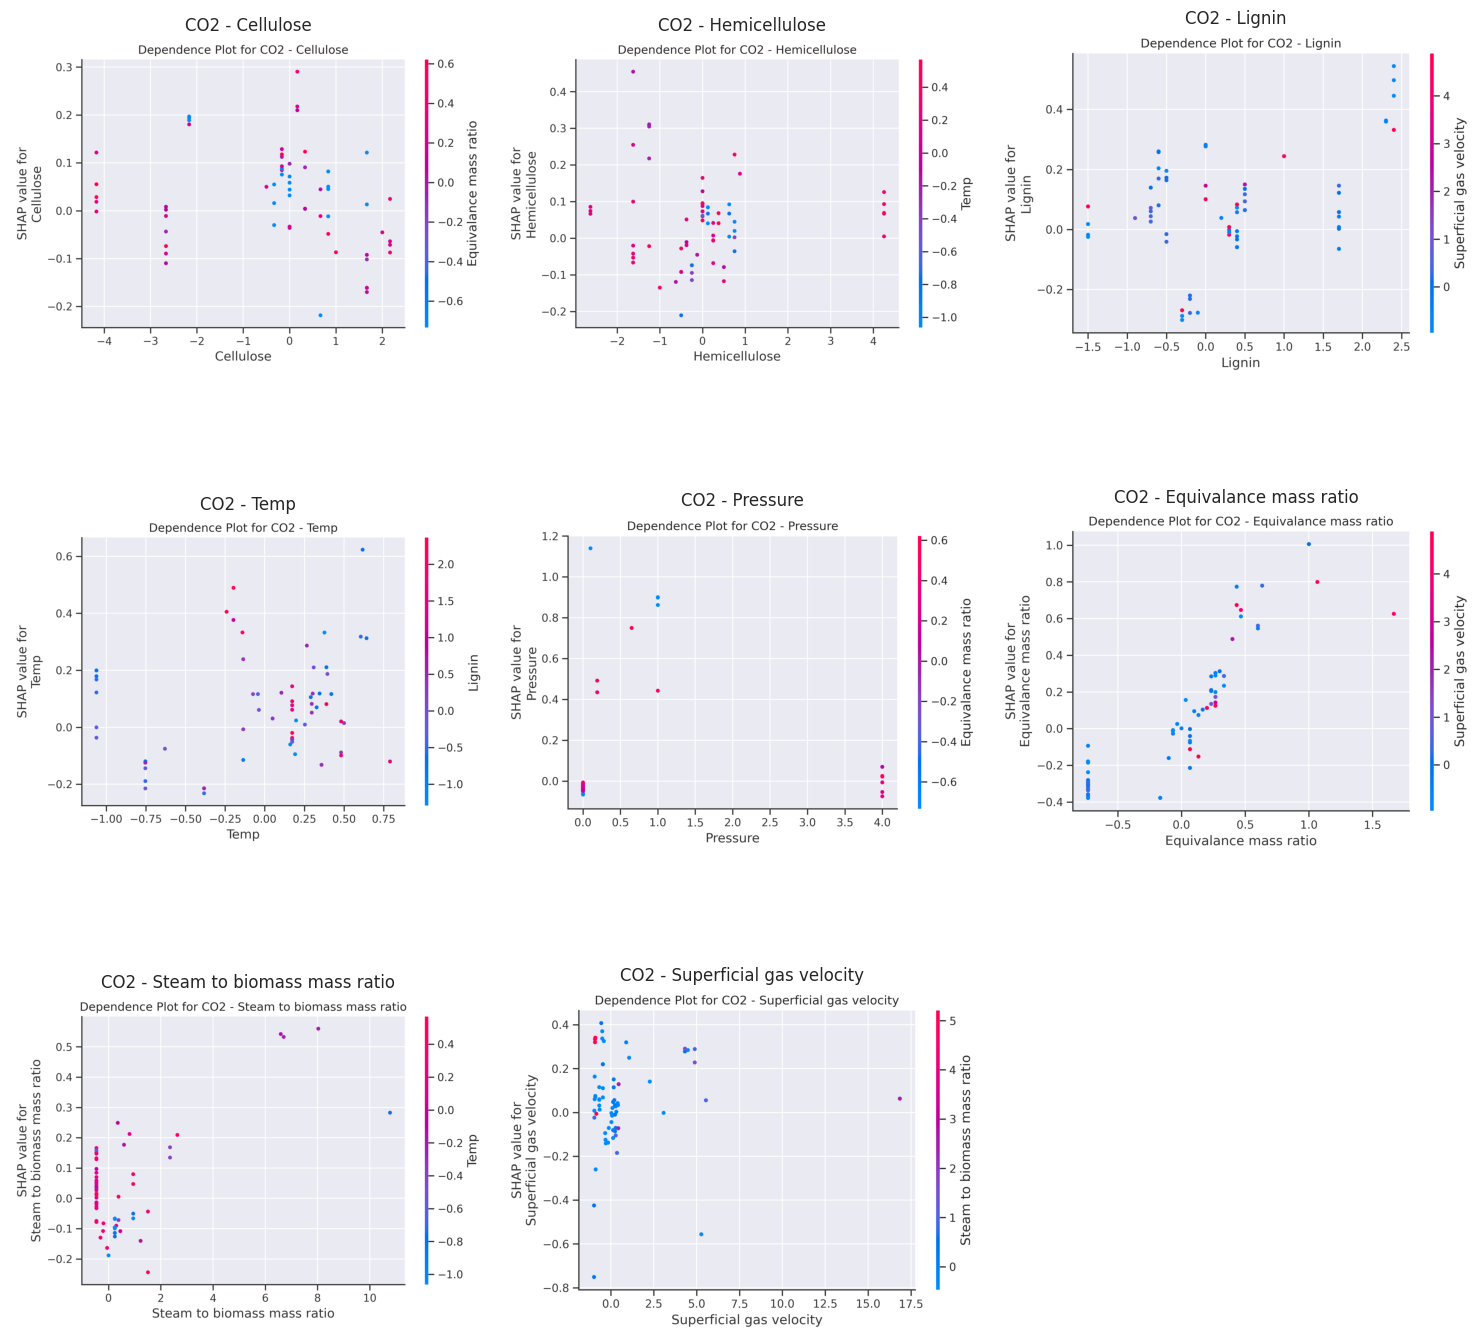

Combining plots for target variable: CH4


<Figure size 1170x827 with 0 Axes>

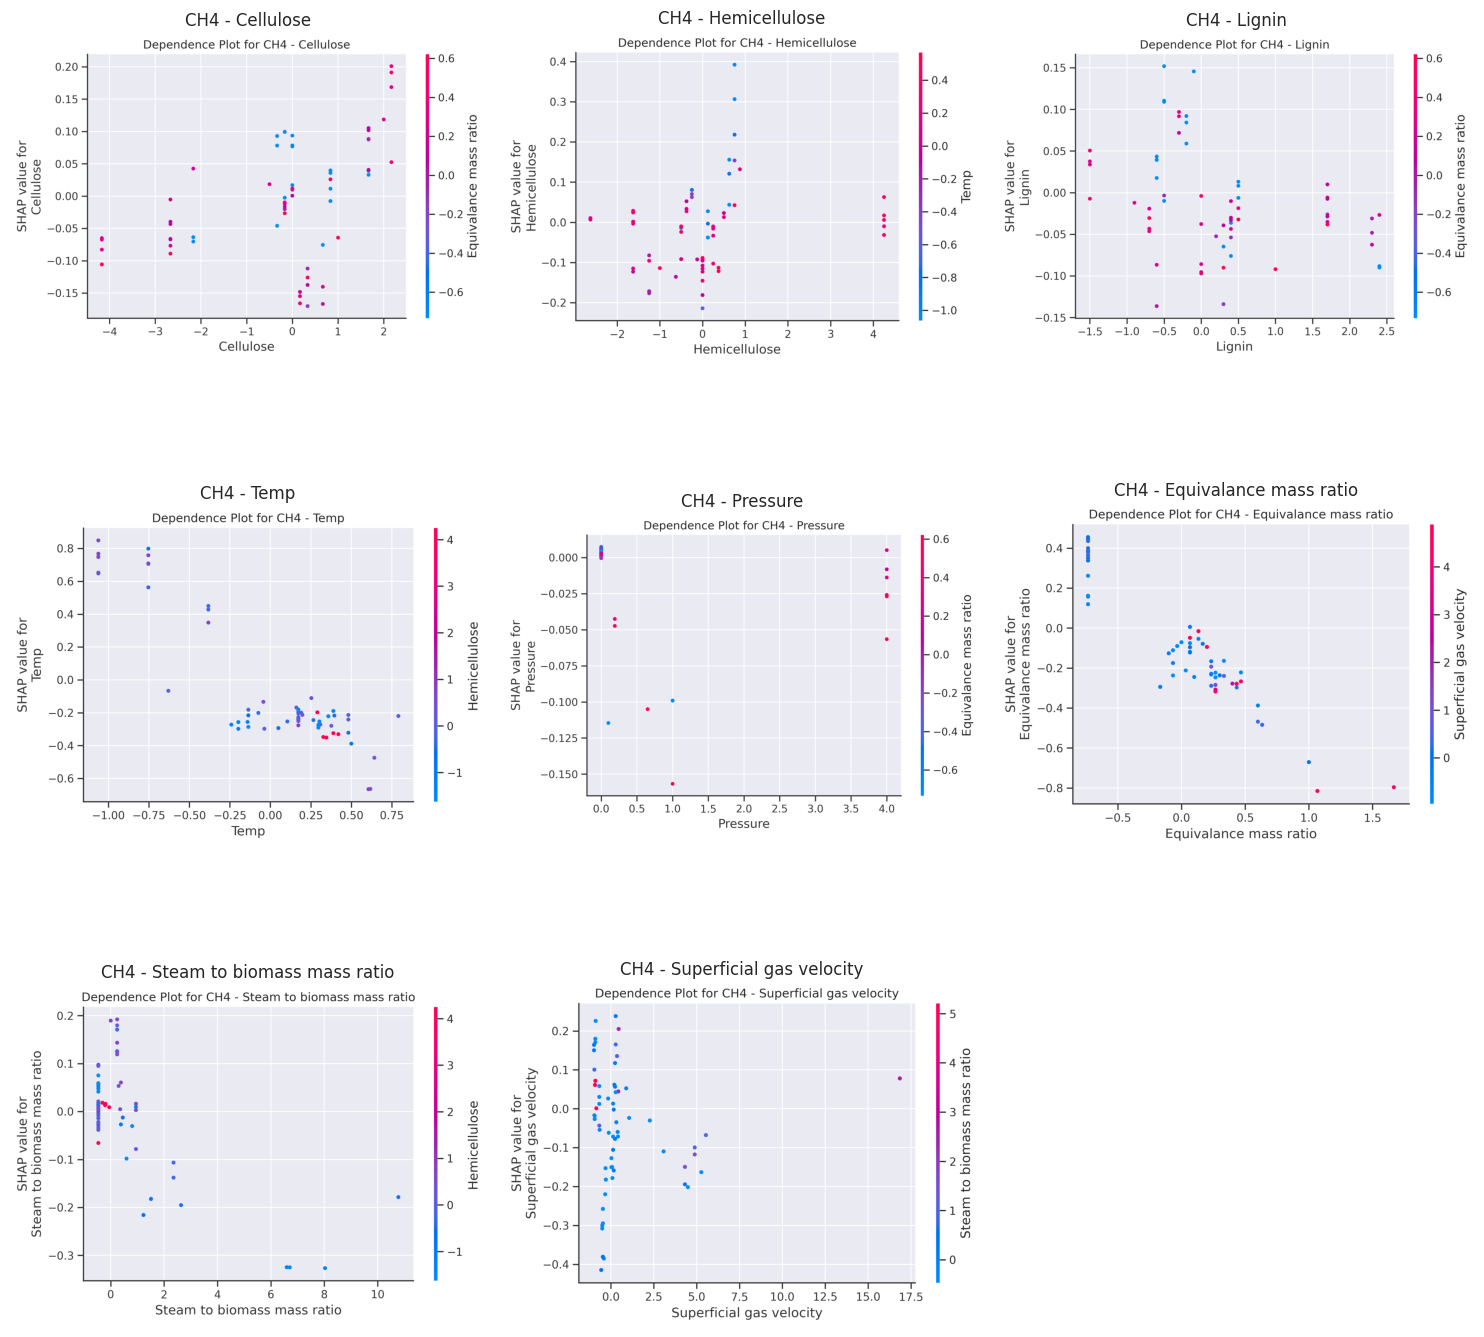

Combining plots for target variable: Lower heating value


<Figure size 1170x827 with 0 Axes>

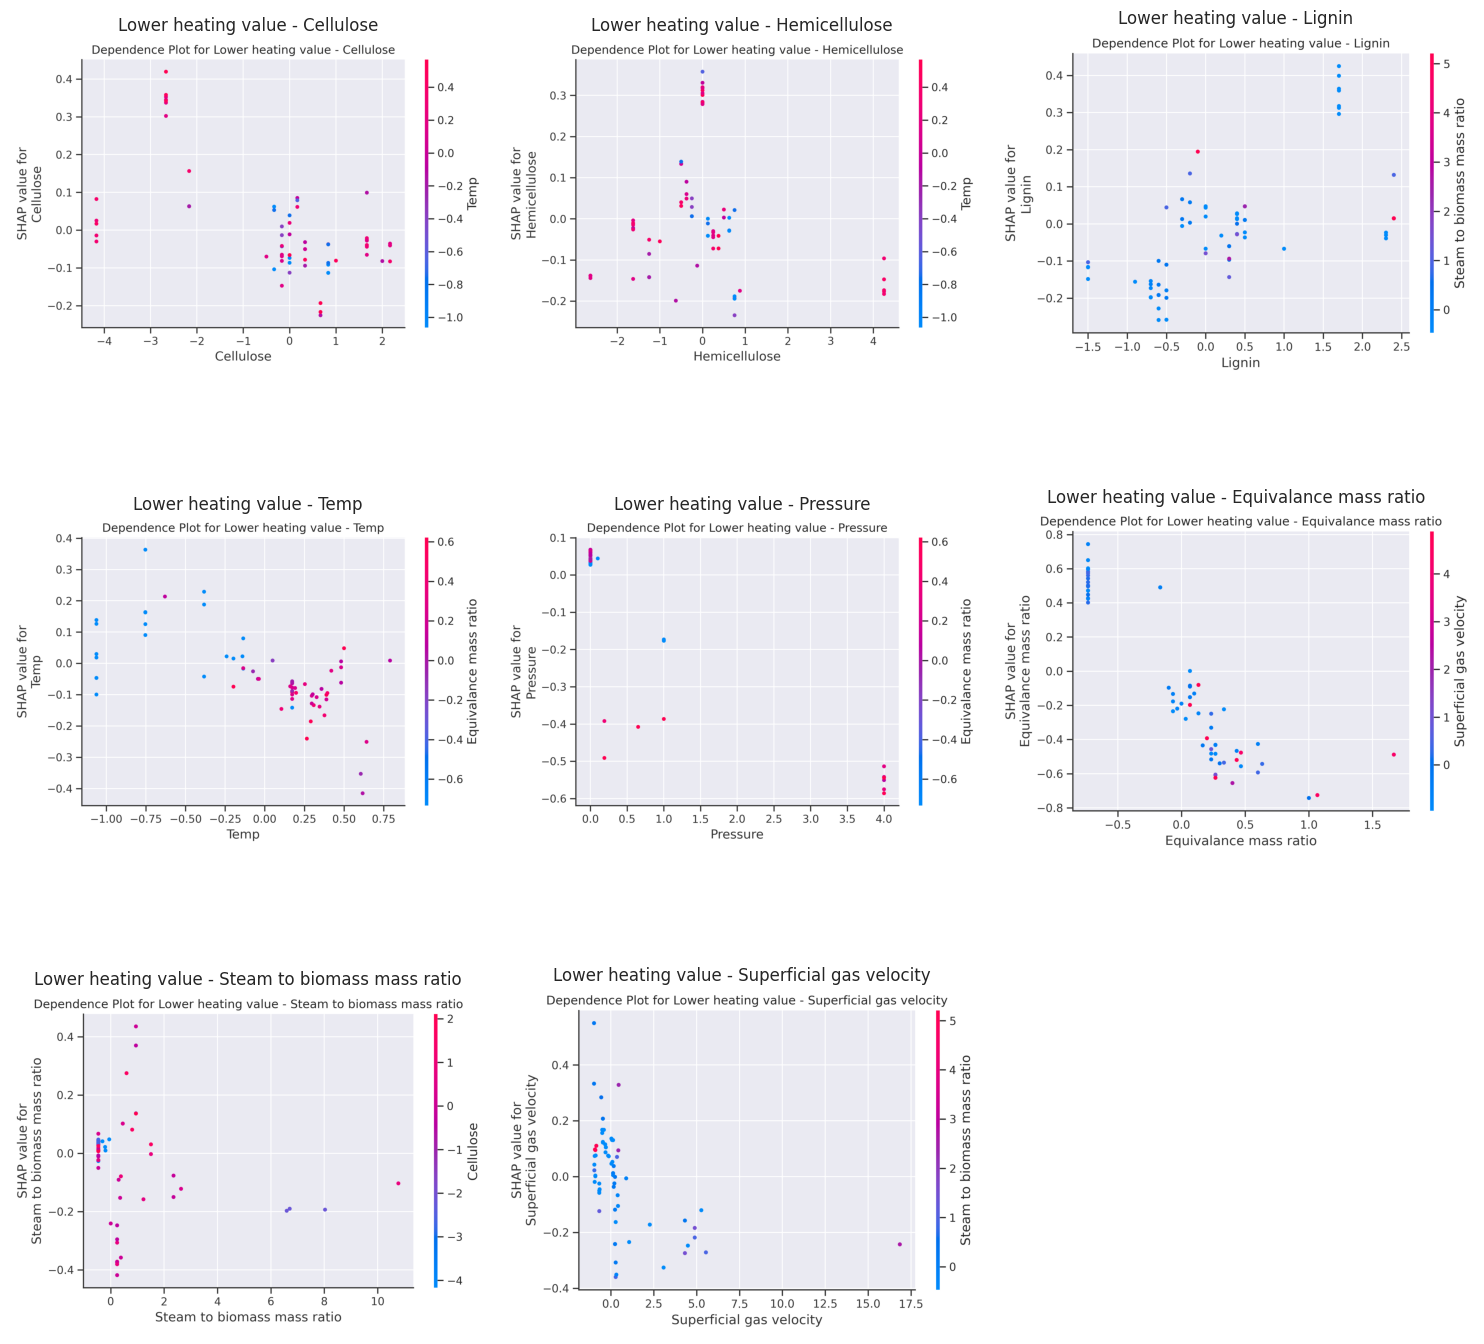

Combining plots for target variable: Char yield


<Figure size 1170x827 with 0 Axes>

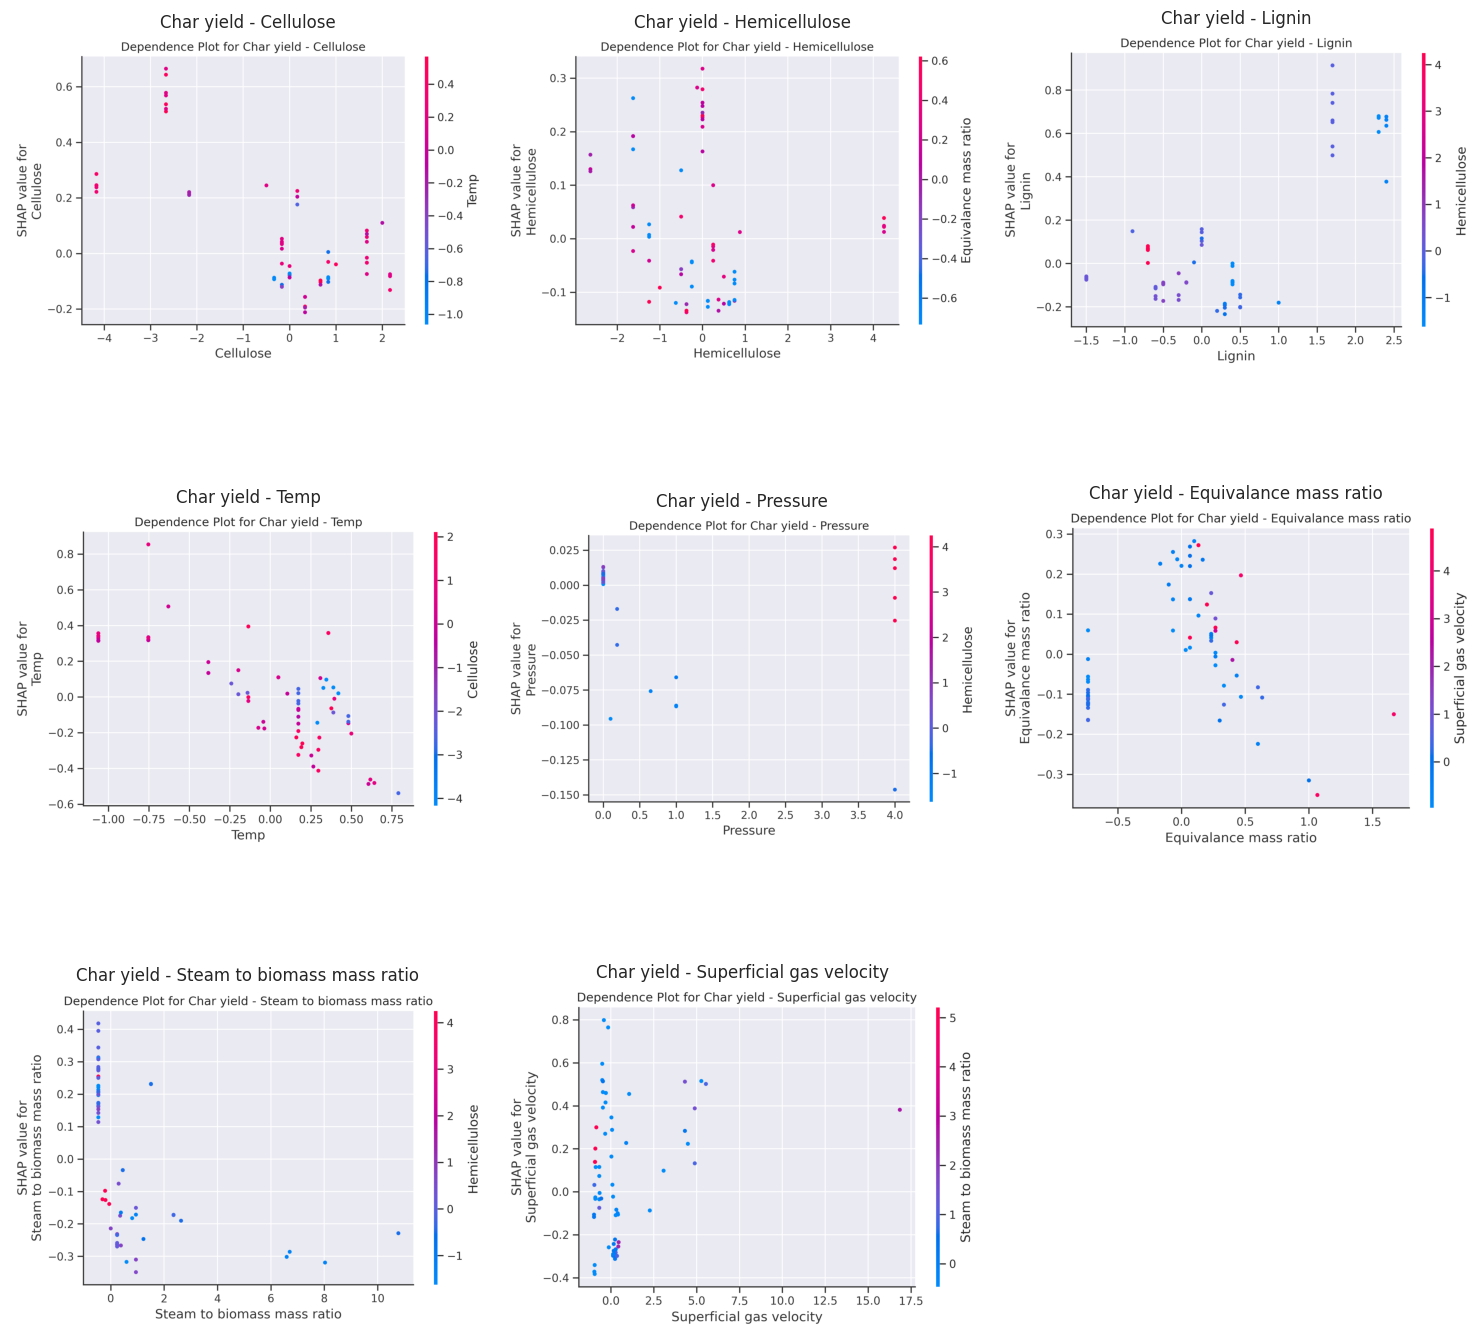

Combining plots for target variable: tar yield


<Figure size 1170x827 with 0 Axes>

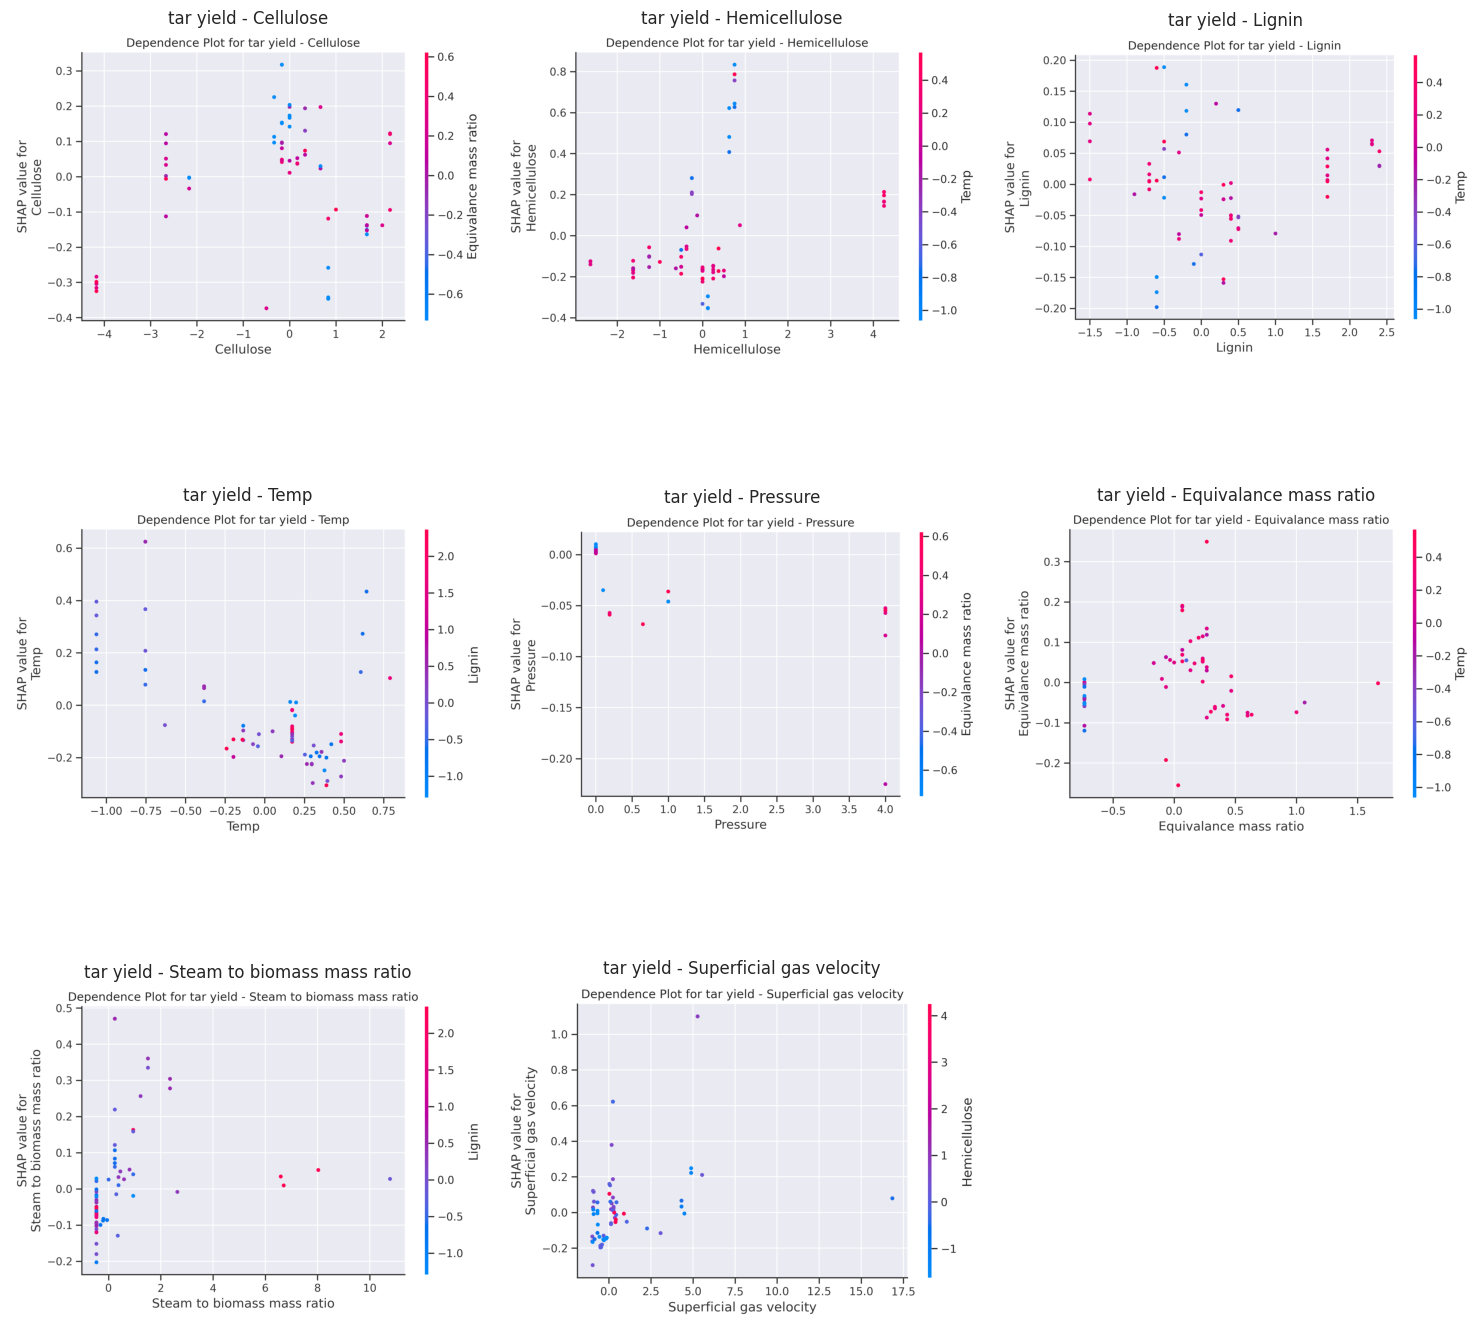

<Figure size 1170x827 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import shap
import os
from sklearn.inspection import PartialDependenceDisplay

# Directory to save individual SHAP dependence plots
if not os.path.exists('shap_dependence_plots'):
    os.makedirs('shap_dependence_plots')

# Directory to save individual PDP plots
if not os.path.exists('pdp_plots'):
    os.makedirs('pdp_plots')

# Loop over each target variable and generate SHAP dependence plots for each feature
for i, target_column in enumerate(y.columns):
    print(f"SHAP dependence plots for target variable: {target_column}")

    # SHAP values for each target separately
    explainer = shap.Explainer(model, X_train)

    # Compute SHAP values (for X_test)
    shap_values = explainer(X_test)

    # Extract the SHAP values for the current target (i-th target)
    shap_values_for_target = shap_values[..., i]

    # Generate dependence plots for each feature
    for feature in X_test.columns:
        shap.dependence_plot(feature, shap_values_for_target.values, X_test, show=False)
        plt.title(f"Dependence Plot for {target_column} - {feature}")
        plt.savefig(f'shap_dependence_plots/shap_dependence_{target_column}_{feature}.png', dpi=300, bbox_inches='tight')
        plt.close()

    # Generate Partial Dependence Plots for the current target variable
    print(f"Generating Partial Dependence Plots for target variable: {target_column}")
    features = [feature for feature in X_test.columns]  # List of features for PDP
    display = PartialDependenceDisplay.from_estimator(
        model,
        X_test,
        features,
        target=i,  # Specify the target index
        grid_resolution=50,  # Adjust resolution as necessary
        n_jobs=-1  # Use all available cores
    )

    plt.title(f"Partial Dependence Plots for {target_column}")
    plt.savefig(f'pdp_plots/pdp_{target_column}.png', dpi=300)
    plt.close()

# Now, combine all the individual SHAP dependence plots into a grid for each target variable
num_columns = 3
num_rows = (len(X_test.columns) + num_columns - 1) // num_columns

# Loop through each target variable to add the saved images to the subplots
for i, target_column in enumerate(y.columns):
    print(f"Combining plots for target variable: {target_column}")

    # Create a figure for combining the plots for this target variable
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    # Loop through each feature and add to the grid
    for j, feature in enumerate(X_test.columns):
        img_path = f'shap_dependence_plots/shap_dependence_{target_column}_{feature}.png'

        # Check if the image file exists
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            axes[j].imshow(img)
            axes[j].axis('off')  # Hide axes
            axes[j].set_title(f"{target_column} - {feature}")
        else:
            print(f"Warning: File {img_path} not found.")

    # Hide any unused subplots for this target variable
    for k in range(len(X_test.columns), len(axes)):
        axes[k].set_visible(False)

    # Adjust layout and spacing
    plt.subplots_adjust(hspace=0.2)  # Adjust the space between rows
    plt.tight_layout()  # Use tight layout after adjusting hspace
    plt.savefig(f'SHAP_dependence_combined_{target_column}.png', dpi=300)
    plt.show()

    # Clear the current figure for the next target variable
    plt.clf()

Generating Partial Dependence Plots for target variable: H2
Generating Partial Dependence Plots for target variable: CO
Generating Partial Dependence Plots for target variable: CO2
Generating Partial Dependence Plots for target variable: CH4
Generating Partial Dependence Plots for target variable: Lower heating value
Generating Partial Dependence Plots for target variable: Char yield
Generating Partial Dependence Plots for target variable: tar yield


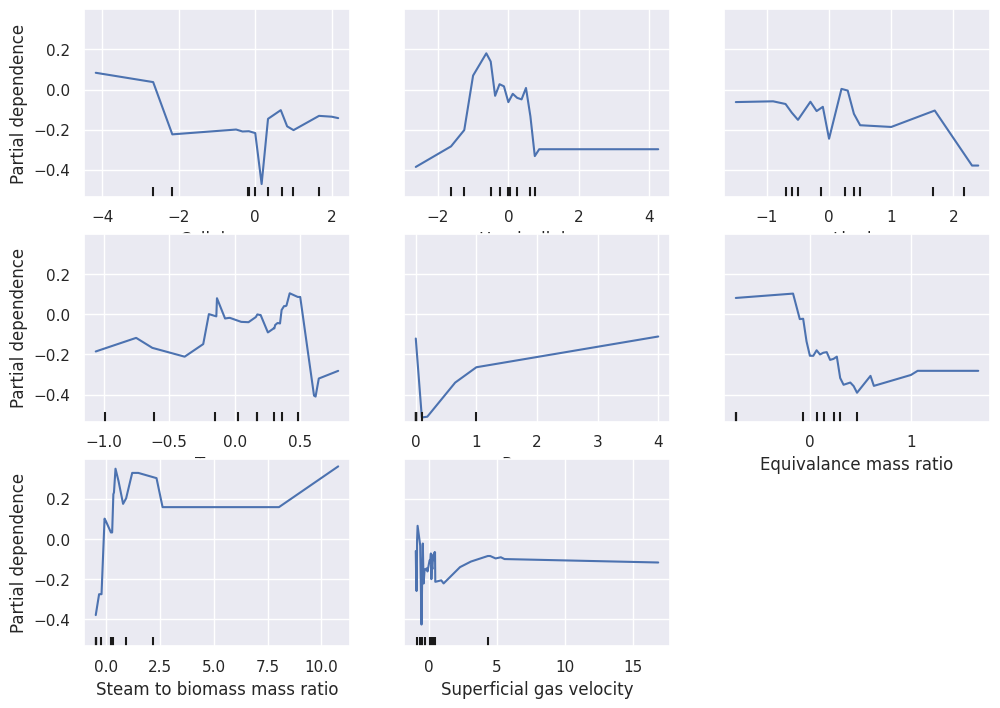

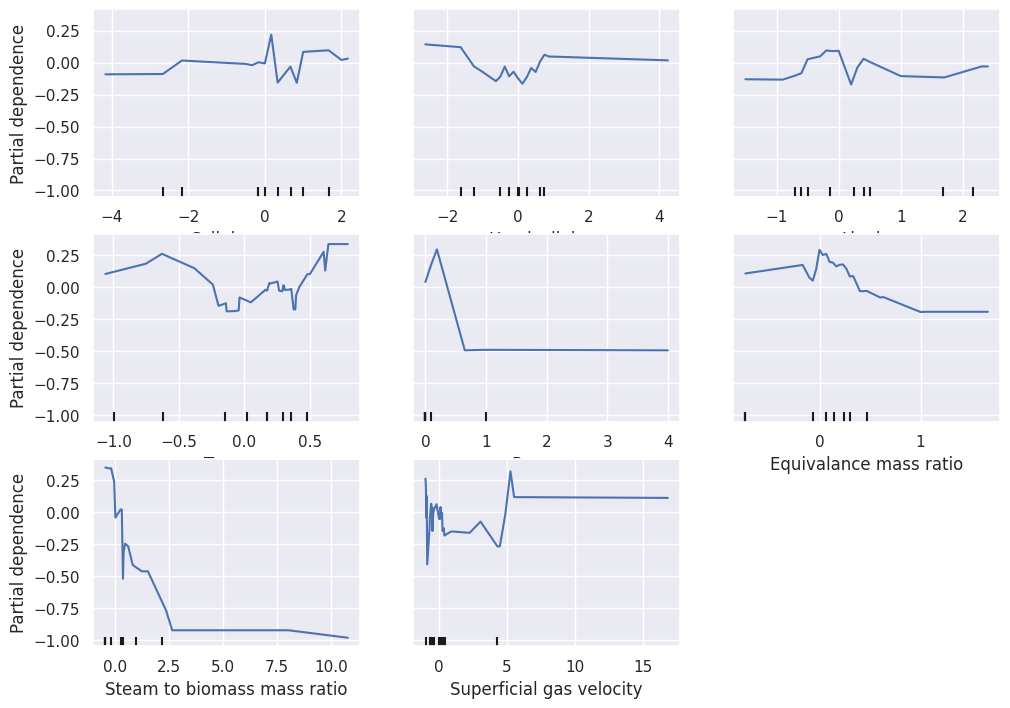

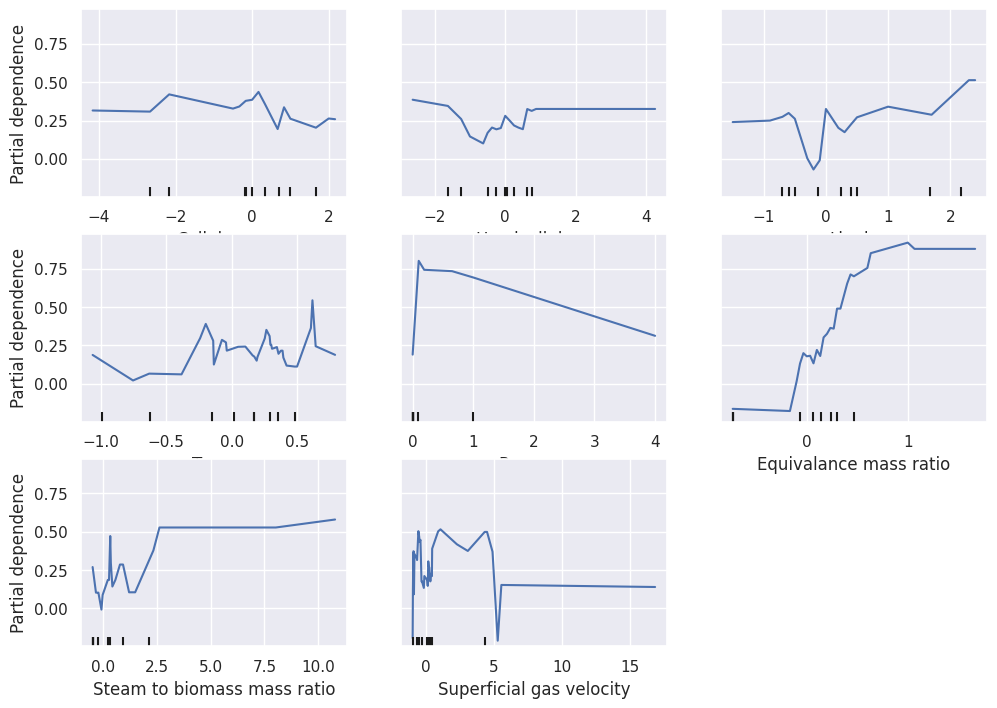

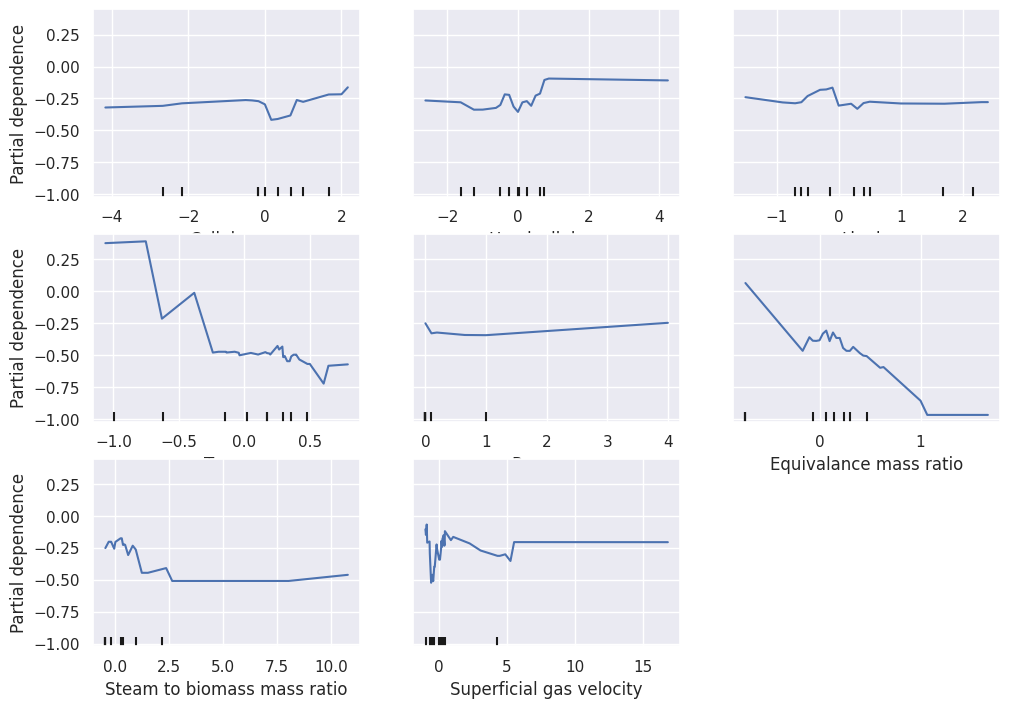

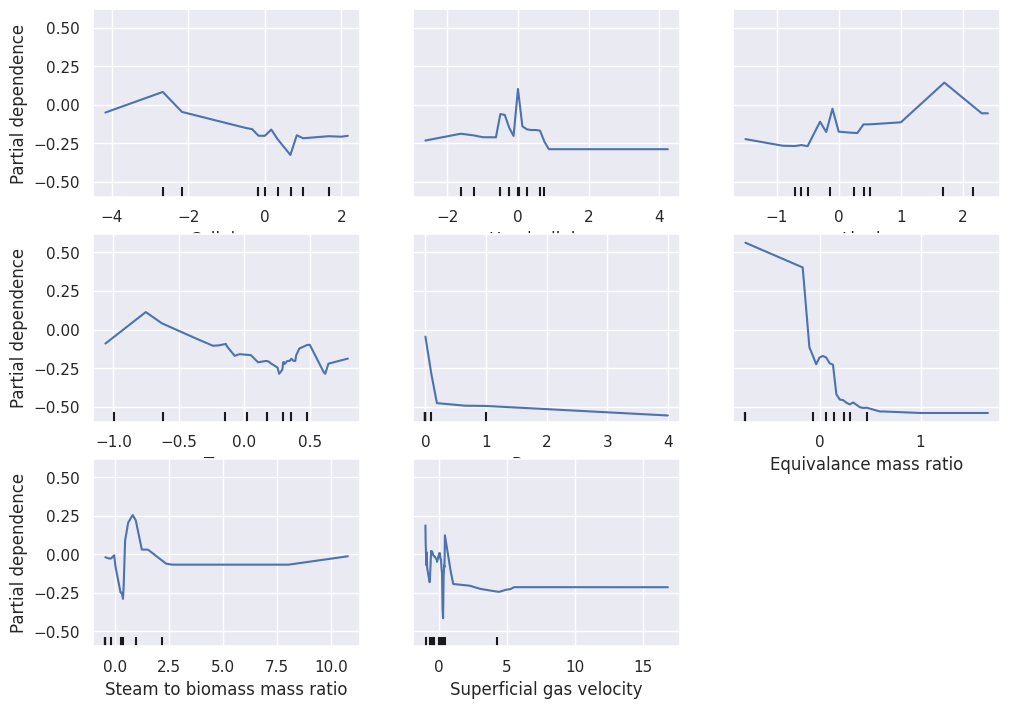

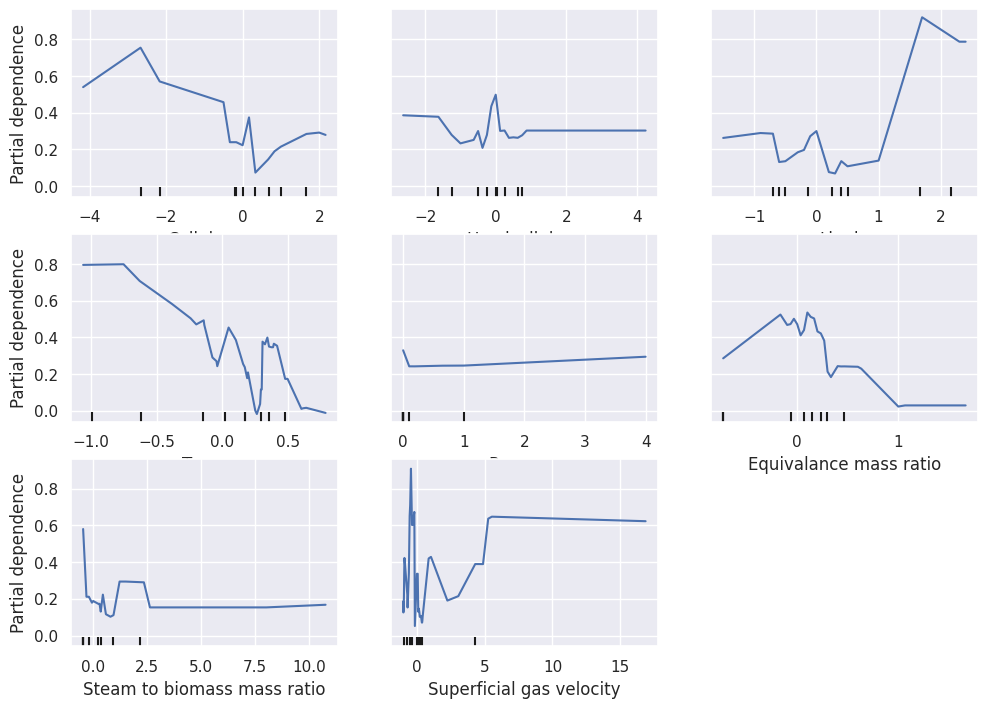

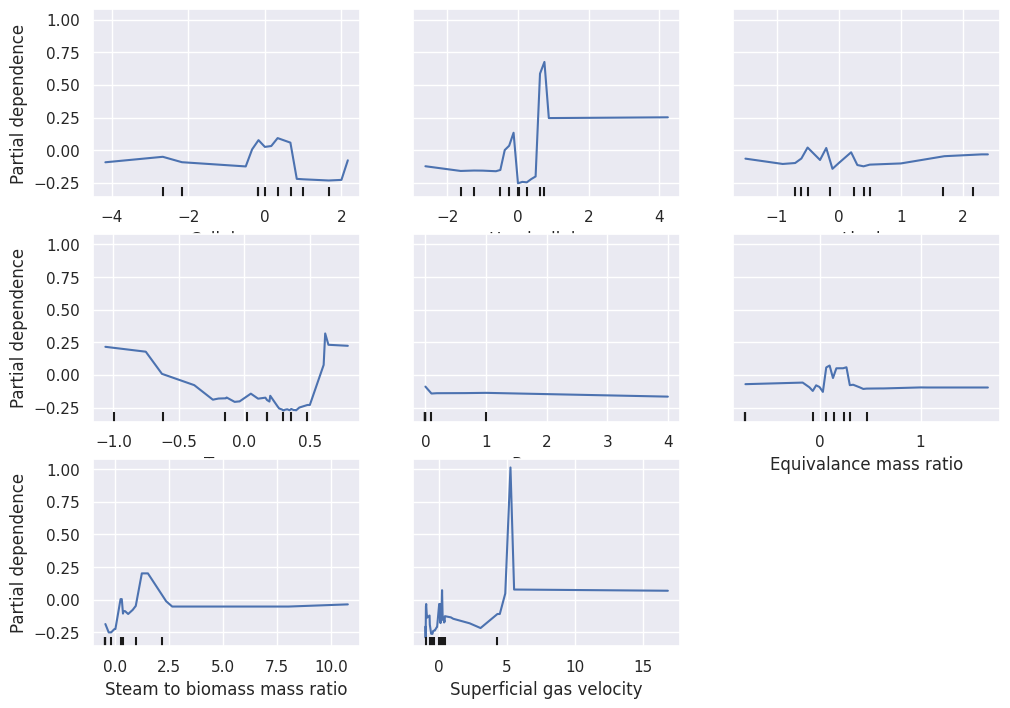

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Loop over each target variable and generate Partial Dependence Plots
for i, target_column in enumerate(y.columns):
    print(f"Generating Partial Dependence Plots for target variable: {target_column}")

    # Create the partial dependence display
    display = PartialDependenceDisplay.from_estimator(
        model,
        X_test,
        features,
        target=i,  # Specify the target index
        grid_resolution=50,  # Adjust resolution as necessary
        n_jobs=-1  # Use all available cores
    )

    # Set the figure size and title
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Partial Dependence Plots for {target_column}", fontsize=16, y=0.95)

    # Adjust the layout to make room for the x-axis labels
    plt.subplots_adjust(bottom=0.2, hspace=0.5)

    # Display the plots
    display.plot(ax=plt.gca())

    # Check if axes exist and customize the x-axis labels to prevent overlap
    if display.axes_ is not None:
        for ax in display.axes_.flatten():
            if ax is not None:  # Check if ax is valid
                ax.set_xlabel(ax.get_xlabel(), fontsize=10, labelpad=10)

    # Save the plot for the current target variable
    plt.savefig(f'pdp_plots/pdp_{target_column}.png', dpi=300)
    plt.close()

# **Model= LightGBM-Gradient Boosting Decision Tree (GBDT)**

***Implementing a simple LightGBM with MultioutputRegressor Wrapper***

In [ ]:
#A LightGBM Model
# Creating a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Defining hyperparameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'num_iterations': 1000,
    'n_estimators': 100
}


# Training the LightGBM model
lgb_model = lgb.LGBMRegressor(**params)
model = MultiOutputRegressor(lgb_model)
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

#calculating the  (RMSE) values for each output separately
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE Scores:", rmse_scores)

#Calculating the coefficient of determination (R-squared or R^2 score) for each output separately.
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
print("R^2 Scores:", r2_scores)

***HyperParameter Tunning of the LightGBM model***

Objective;
  - To obtain and implement the best_parameter on the LightGBM

In [ ]:

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),

        "verbosity": 0,
    }
    gbm = lgb.LGBMRegressor(**params)
    model = MultiOutputRegressor(gbm)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=True)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)


***Implementing the obtained best_param on the LightGBM model***

In [ ]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define hyperparameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate':  0.008205225520475734,
    'num_leaves': 309,
    'subsample': 0.41539469896846515,
    'colsample_bytree':0.7262726367786536,
    'num_iterations': 900,
    'n_estimators': 700,

    'reg_alpha': 0.3297803728412838,
    'reg_lambda': 0.034138739525795436,

    'min_data_in_leaf': 1,
}
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'learning_rate': 0.0413163182901069,
#     'num_leaves': 457,
#     'subsample': 0.10278012109662671,
#     'colsample_bytree':0.6931843908439858,
#     'num_iterations': 900,
#     'n_estimators': 800,

#     'reg_alpha': 0.4903706994035554,
#     'reg_lambda': 0.7460516923672987,

#     'min_data_in_leaf': 1,
# }
# Train the LightGBM model
gbm = lgb.LGBMRegressor(**params)
model = MultiOutputRegressor(gbm)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE scores
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
print("RMSE Scores:", rmse_scores)

# Calculate R^2 scores
r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
print("R^2 Scores:", r2_scores)

r2_scores = r2_score(y_test, y_pred)
print("R^2 Scores:", r2_scores)


residuals = y_test - y_pred
plt.figure(figsize=(20, 5))
plt.hist(residuals, bins=10)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

# Calculate and print R^2 value
r2_total = r2_score(y_test, y_pred, multioutput='variance_weighted')
plt.text(0.5, 0.9, f'Total R^2 = {r2_total:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()
plt.figure(figsize=(10, 5))
sns.violinplot(y=y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Violin Plot of Predicted Values for Each True Value')
plt.show()

num_columns = 3

# Calculate the number of rows needed
num_rows = (len(targets.columns) + num_columns - 1) // num_columns

# Create subplots with a smaller figsize
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each target variable
for i, target_column in enumerate(targets.columns):
    # Scatter plot
    axes[i].scatter(y_test[:, i], y_pred[:, i], label='True vs Predicted')

    # Diagonal line for reference
    axes[i].plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], color='red', linewidth=2)

    # Calculate and print R^2 value
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    axes[i].text(0.5, 0.9, f'R^2 = {r2:.2f}', ha='center', va='center', transform=axes[i].transAxes)

    axes[i].set_xlabel(f'True Values ({target_column})')
    axes[i].set_ylabel(f'Predicted Values ({target_column})')
    axes[i].set_title(f'True vs Predicted Values LightGBM({target_column})')
    axes[i].legend()

plt.tight_layout()

# Save the figure
fig.savefig('lightGBM_figure.png')

# Show the figure
plt.show()

# **Model= RandomForestRegressor**

Random Forest RMSE Scores: [0.41727304 0.57330059 0.43377421 0.37200389 0.37302761 0.57272173
 0.38189032]
Random Forest R^2 Scores: [0.85710794 0.740445   0.82960966 0.87052504 0.84358803 0.67673548
 0.81065407]


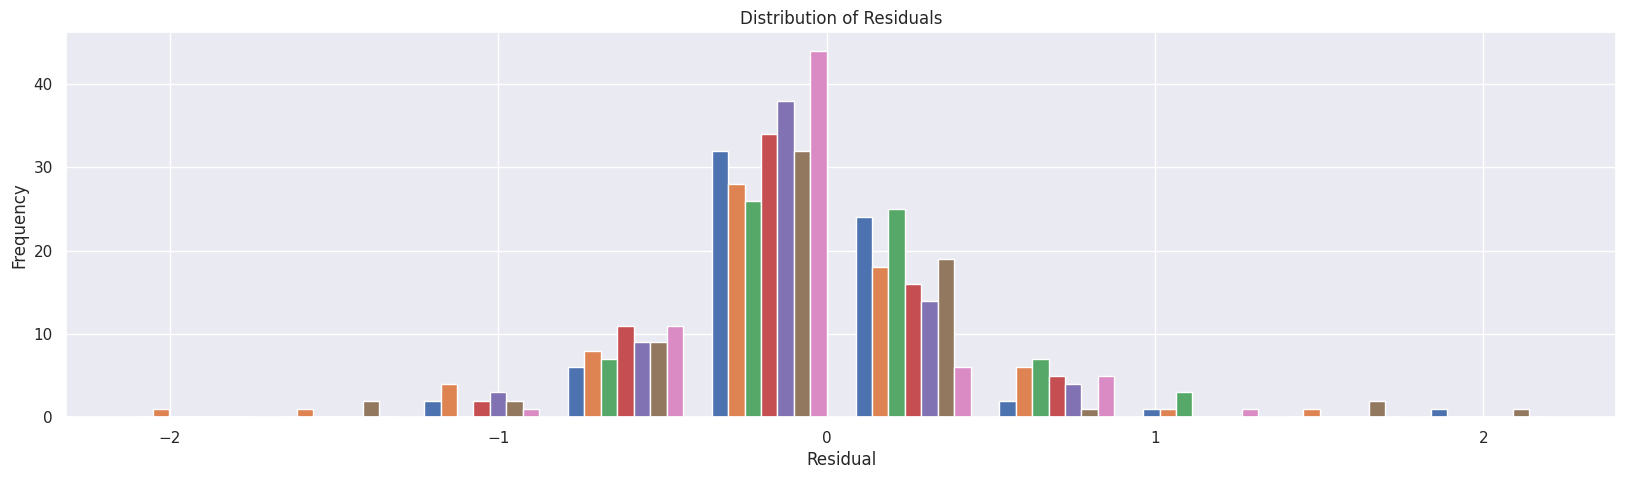

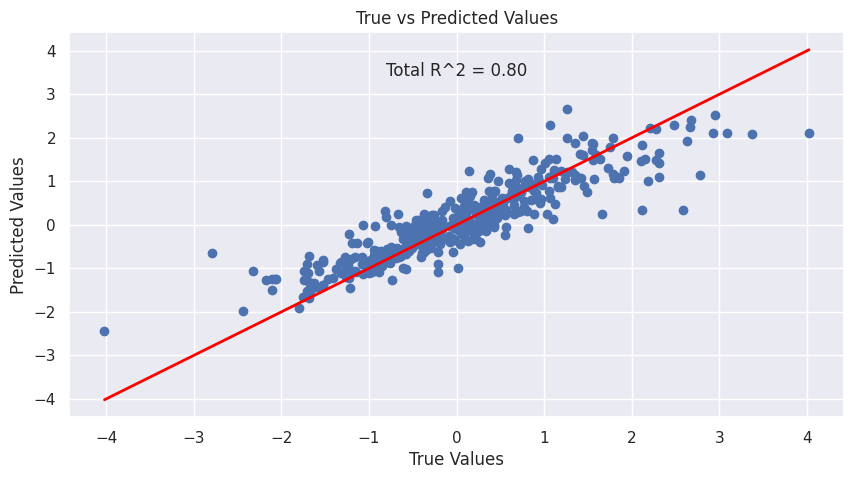

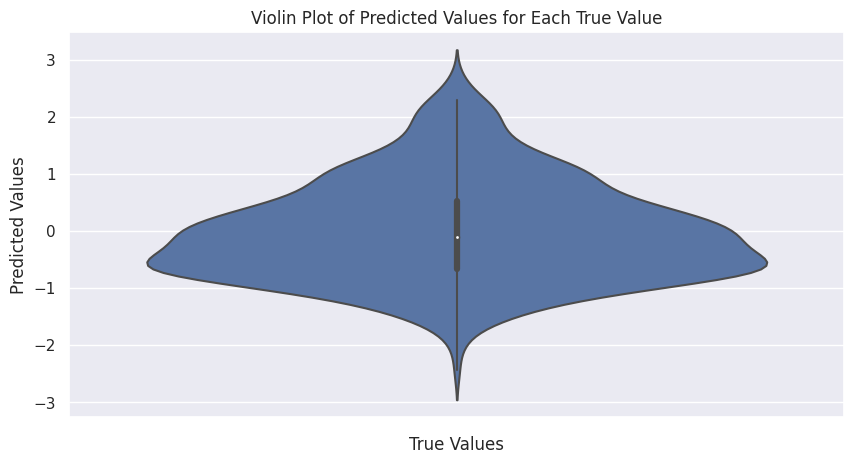

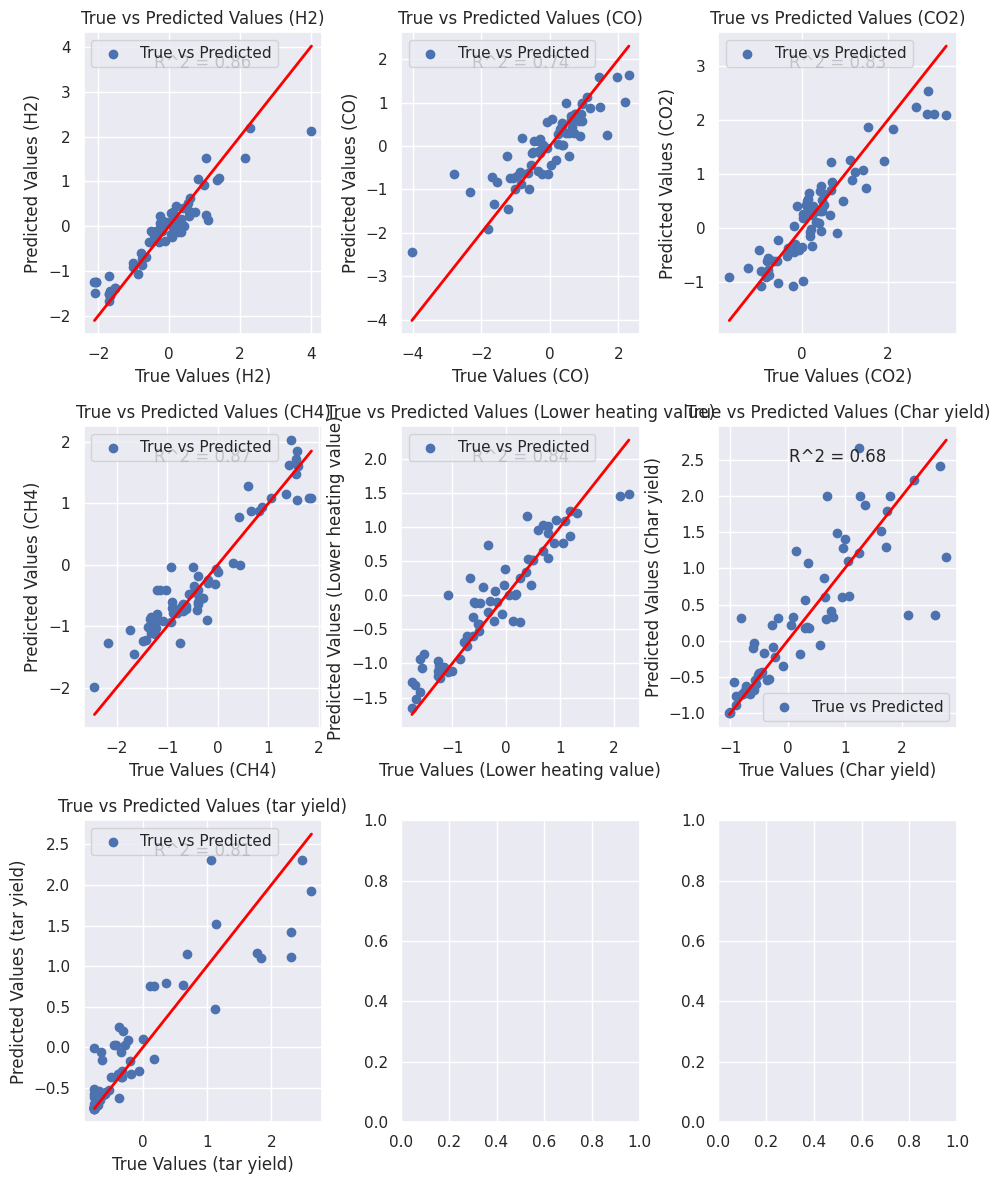

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
np.random.seed(42)
# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions, multioutput='raw_values'))
rf_r2 = r2_score(y_test, rf_predictions, multioutput='raw_values')
print("Random Forest RMSE Scores:", rf_rmse)
print("Random Forest R^2 Scores:", rf_r2)

residuals = y_test - rf_predictions

plt.figure(figsize=(20, 5))
plt.hist(residuals, bins=10)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, rf_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

# Calculate and print R^2 value
r2_total = r2_score(y_test, rf_predictions, multioutput='variance_weighted')
plt.text(0.5, 0.9, f'Total R^2 = {r2_total:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()
plt.figure(figsize=(10, 5))
sns.violinplot(y=rf_predictions)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Violin Plot of Predicted Values for Each True Value')
plt.show()

num_columns = 3

# Calculate the number of rows needed
num_rows = (len(targets.columns) + num_columns - 1) // num_columns

# Create subplots with a smaller figsize
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each target variable
for i, target_column in enumerate(targets.columns):
    # Scatter plot
    axes[i].scatter(y_test[:, i], rf_predictions[:, i], label='True vs Predicted')

    # Diagonal line for reference
    axes[i].plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], color='red', linewidth=2)

    # Calculate and print R^2 value
    r2 = r2_score(y_test[:, i], rf_predictions[:, i])
    axes[i].text(0.5, 0.9, f'R^2 = {r2:.2f}', ha='center', va='center', transform=axes[i].transAxes)

    axes[i].set_xlabel(f'True Values ({target_column})')
    axes[i].set_ylabel(f'Predicted Values ({target_column})')
    axes[i].set_title(f'True vs Predicted Values ({target_column})')
    axes[i].legend()

plt.tight_layout()

# Save the figure
fig.savefig('RandomForest_figure.png')

# Show the figure
plt.show()

***RandomForestRegressor Hyperparameter Tunning***

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=10),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),

    }


    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=True)
    return rmse




study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)
print('Best hyperparameters_RandomForest:', study.best_params)
print('Best RMSE:', study.best_value)

***Implementing RandomForestRegressor Best_params***_

Random Forest RMSE Scores: [0.45413638 0.59890564 0.43667318 0.34843386 0.34452217 0.5482857
 0.35960588]
Random Forest R^2 Scores: [0.83074557 0.7167425  0.82732457 0.88641224 0.86657956 0.70373212
 0.83210713]
Random Forest R^2 Scores: 0.8090919554431774


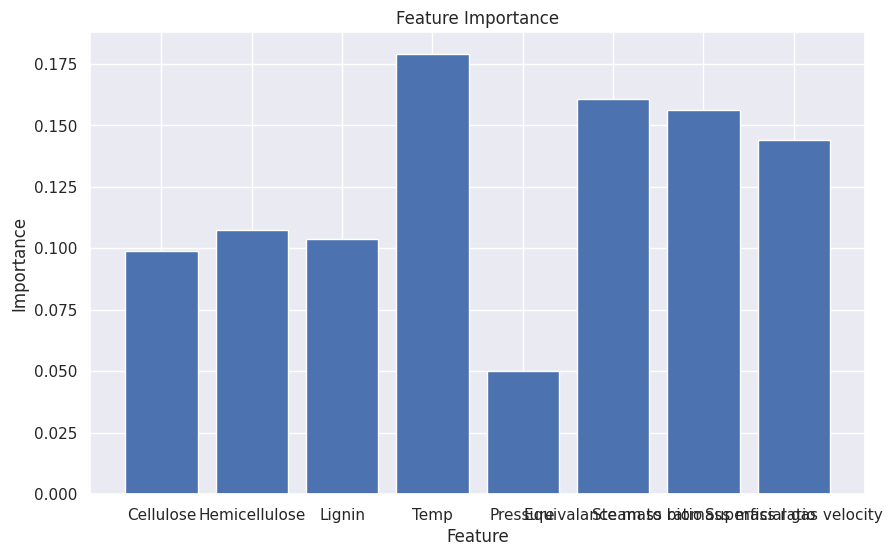

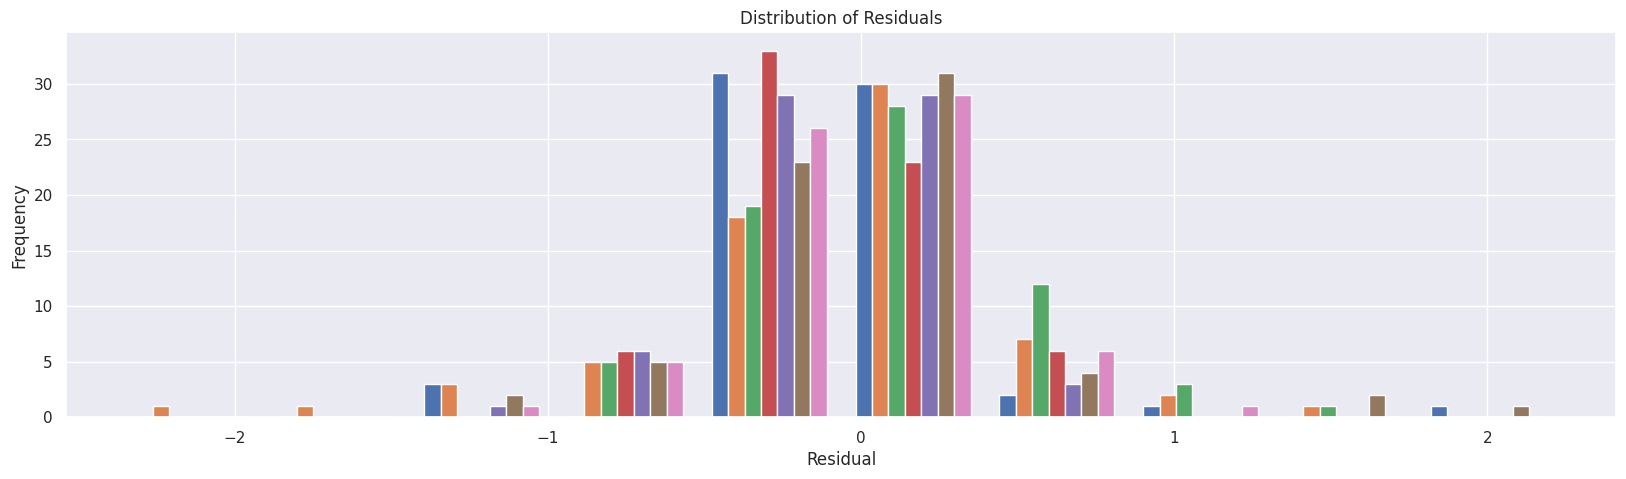

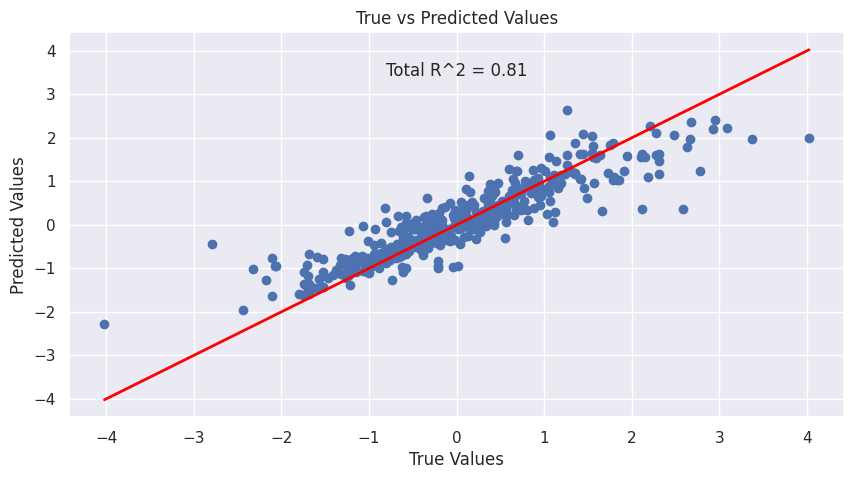

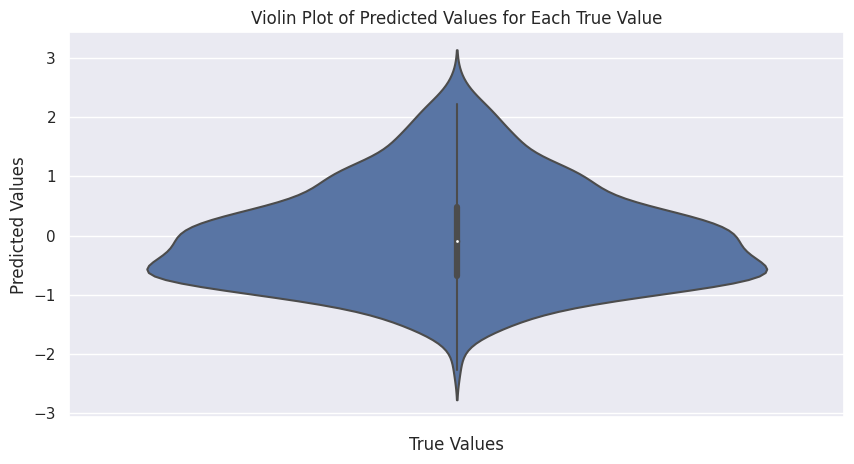

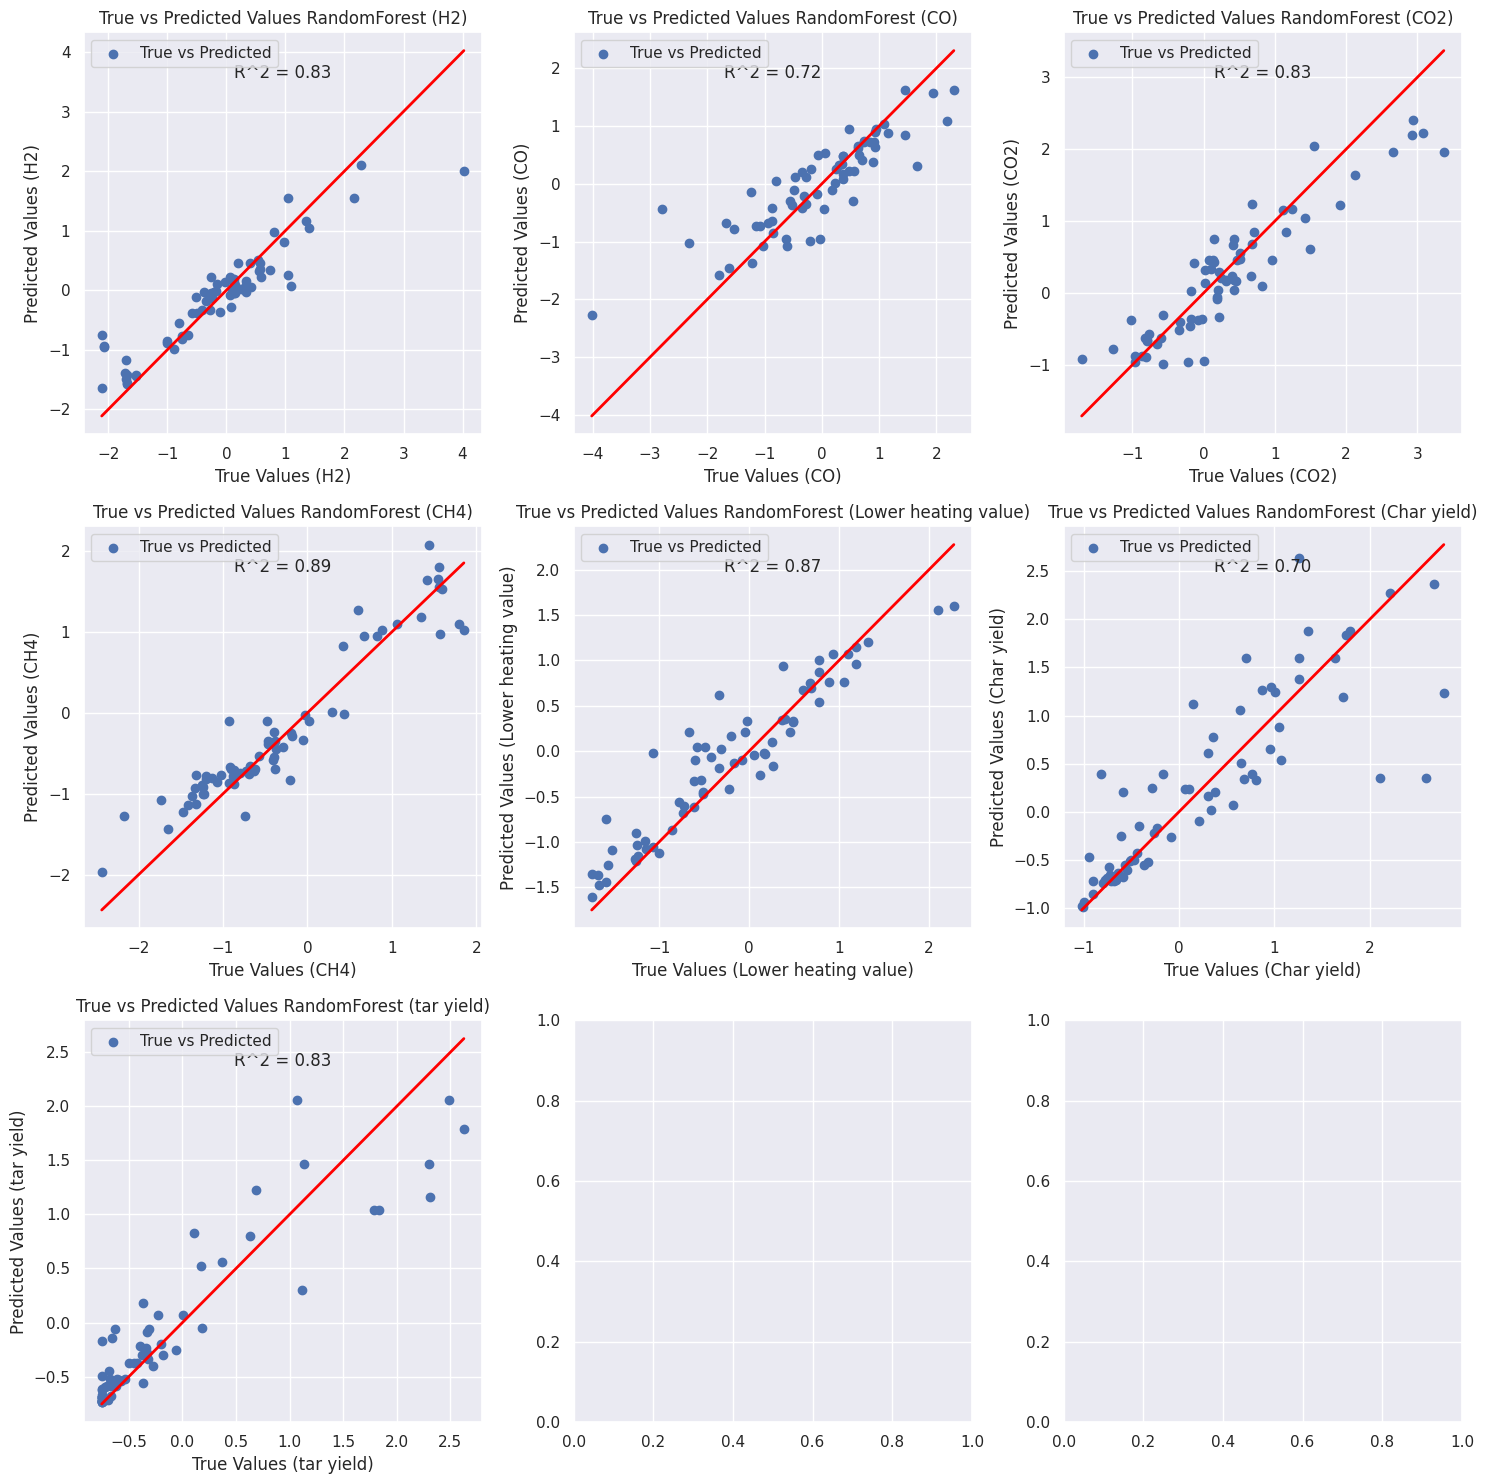

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
np.random.seed(12)
# Set the given parameters


params = {
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 430,
}


# Create the Random Forest model with the given parameters
rf_model = RandomForestRegressor(**params)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
rf_predictions = rf_model.predict(X_test)

# Calculate RMSE scores
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions, multioutput='raw_values'))
print("Random Forest RMSE Scores:", rf_rmse)

# Calculate R^2 scores
rf_r2 = r2_score(y_test, rf_predictions, multioutput='raw_values')
print("Random Forest R^2 Scores:", rf_r2)
r1 = r2_score(y_test, rf_predictions)
print("Random Forest R^2 Scores:", r1)




# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = ['Cellulose', 'Hemicellulose', 'Lignin', 'Temp', 'Pressure', 'Equivalance mass ratio', 'Steam to biomass mass ratio', 'Superficial gas velocity']
# feature importances plottings with feature names
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align="center")
plt.xticks(range(len(feature_importances)), feature_names)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

###Residual Analysis
#Residuals Distribution Plot
residuals = y_test - rf_predictions
plt.figure(figsize=(20, 5))
plt.hist(residuals, bins=10)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

###True vs Predicted Scatter Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test, rf_predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

# Calculate and print R^2 value
r2_total = r2_score(y_test, rf_predictions, multioutput='variance_weighted')
plt.text(0.5, 0.9, f'Total R^2 = {r2_total:.2f}', ha='center', va='center', transform=plt.gca().transAxes)


##True vs Predicted violin plot
plt.show()
plt.figure(figsize=(10, 5))
sns.violinplot(y=rf_predictions)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Violin Plot of Predicted Values for Each True Value')
plt.show()

####"True vs Predicted Multiple Scatter Plots with R^2 Values and Diagonal Line
num_columns = 3

# Calculate the number of rows needed
num_rows = (len(targets.columns) + num_columns - 1) // num_columns

# Create subplots with a smaller figsize
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each target variable
for i, target_column in enumerate(targets.columns):
    # Scatter plot
    axes[i].scatter(y_test[:, i], rf_predictions[:, i], label='True vs Predicted')

    # Diagonal line for reference
    axes[i].plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], color='red', linewidth=2)

    # Calculate and print R^2 value
    r2 = r2_score(y_test[:, i], rf_predictions[:, i])
    axes[i].text(0.5, 0.9, f'R^2 = {r2:.2f}', ha='center', va='center', transform=axes[i].transAxes)

    axes[i].set_xlabel(f'True Values ({target_column})')
    axes[i].set_ylabel(f'Predicted Values ({target_column})')
    axes[i].set_title(f'True vs Predicted Values RandomForest ({target_column})')
    axes[i].legend()

plt.tight_layout()

# Save the figure
fig.savefig('RandomForest_figure.png')

# Show the figure
plt.show()



In [ ]:
import sklearn
print(sklearn.__version__)

1.5.dev0


# **Evaluating the P_values of the Features **

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Assume you have already trained a Random Forest model and have X, y, and y_test defined

# Store the original root mean squared error (RMSE) from the Random Forest model
original_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

# Obtain the feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Normalize the feature importances
normalized_importances = feature_importances / np.sum(feature_importances)

# Perform permutation test for each feature
n_permutations = 1000  # Number of permutations
permutation_rmse_decreases = []

for feature_idx in range(X.shape[1]):
    # Permute the values of the feature
    permuted_X = X_test.copy()
    permuted_X[:, feature_idx] = shuffle(permuted_X[:, feature_idx])

    # Calculate the permuted root mean squared error (RMSE) on the test set
    permuted_y_pred = rf_model.predict(permuted_X)
    permuted_rmse = np.sqrt(mean_squared_error(y_test, permuted_y_pred))

    # Calculate the decrease in RMSE compared to the original predictions
    rmse_decrease = original_rmse - permuted_rmse
    permutation_rmse_decreases.append(rmse_decrease)

# Perform hypothesis testing by comparing the observed decrease in RMSE for each feature
# to the distribution of decreases obtained from permutation
p_values = []
for idx, rmse_decrease in enumerate(permutation_rmse_decreases):
    p_value = (np.sum(rmse_decrease <= permutation_rmse_decreases) + 1) / (n_permutations + 1)
    p_values.append(p_value)

# Print the p-values
for feature_idx, p_value in enumerate(p_values):
    print(f"Feature {feature_idx}: p-value = {p_value}")


Feature 0: p-value = 0.003996003996003996
Feature 1: p-value = 0.004995004995004995
Feature 2: p-value = 0.005994005994005994
Feature 3: p-value = 0.006993006993006993
Feature 4: p-value = 0.002997002997002997
Feature 5: p-value = 0.008991008991008992
Feature 6: p-value = 0.007992007992007992
Feature 7: p-value = 0.001998001998001998
